# Enhancing Speech Emotion Classification by utilizing a Convolutional Neural Network: A deep learning approach to Audio Classification

Emil Vinod¹
## Import Python Modules

In [1]:
import os                          # Operating system-related functionality
from glob import glob              # File pattern matching

In [2]:
import numpy as np                 # Numerical operations
import pandas as pd                # Data manipulation and analysis
import seaborn as sns              # Data visualization
import matplotlib.pylab as plt    # Plotting

In [3]:
from tqdm import tqdm             # Progress bars
from scipy.io import wavfile      # Reading WAV files

In [4]:
import IPython.display as ipd     # Audio playback
import librosa                     # Audio analysis
import librosa.display            # Audio visualization

In [5]:
from sklearn.utils.class_weight import compute_class_weight   # Class weight computation
from python_speech_features import mfcc, logfbank             # Audio feature extraction

In [6]:
from keras.models import Sequential                       # Keras Sequential model
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM   # Keras layers
from keras.layers import Dropout, Dense, TimeDistributed    #Keras Layers
from keras.utils import to_categorical                    # Keras utility functions

In [7]:
from itertools import cycle       # Iterator-based looping

In [8]:
import pickle
from keras.callbacks import ModelCheckpoint
import import_ipynb
from cfg import Config

importing Jupyter notebook from cfg.ipynb


In [9]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
from keras.models import load_model
import tensorflow as tf

## Methodology : Convolutional Neural Network-Based Speech Emotion Recognition

Utilizes the RAVDESS DataSet
Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391. ²

**Preprocessing the Audio Files:**
  - Loading the audio files from the RAVDESS dataset.
  - Applying necessary preprocessing steps such as resampling and normalization to ensure consistency across the data.
  - Performing Fast Fourier Transform (FFT) to analyze the frequency content of the audio samples.
  - Applying downsampling to reduce the sampling rate of the audio data.
  - Generating spectrograms, filter banks and mel frequency cepstrum coefficient to visualize the frequency content of emotional speech over time.
  - Applying Short Time Fourier Transform (STFT) to capture variations in spectral content over short-time intervals.
  - Utilizing a Mel Filterbank to emphasize important frequency bands for emotional analysis.
  - Performing feature engineering to extract additional meaningful features.


**Feature Extraction:**

Extracting relevant features from the preprocessed audio data:
   
  - **MFCC (Mel-Frequency Cepstral Coefficients):** Represent the spectral characteristics of the audio signal.
  - **Fbank (Filter Bank):** A bank of filters that are spaced equally on the mel scale, which is a perceptual scale of pitches.

(Additional) Researched features with potential preprocessing gain:
   
  - **Shimmer:** Measure the variations in amplitude of the speech signal.
  - **Harmonic to Noise Ratio:** Assess the presence of harmonic components in relation to noise.
  - **Voiced and Unvoiced Segments:** Determine the proportion of voiced and unvoiced speech segments.
  - **Alpha ratio and Hammarberg Index:** Additional acoustic features related to speech quality.
  - **Spectral Flux:** Measure the rate of change of the spectral content over time.
  - **Fundamental Frequency:** Extract pitch-related information.
  - **Loudness and Intensity:** Capture the overall sound level and strength.
  - **Jitter:** Quantify the variations in vocal cord vibrations.
  - **Formants (F1, F2, F3):** Identify resonant frequencies in the speech signal.

**Model Integration:**
 - Designing the architecture of the CNN for speech emotion recognition.
 - Including convolutional layers, pooling layers, and fully connected layers in the CNN model.
 - Using the extracted features as input to the CNN for training and inference.
 - Training the CNN model using the labeled audio data from the RAVDESS dataset.

**Evaluation:**
 - Evaluating the performance of the CNN model in terms of emotion recognition accuracy.
 - Measuring the model's ability to classify emotions accurately based on the audio features.

**Further Improvements:**
 - Refining and enhance the feature set based on the results and analysis.
 - Exploring advanced CNN architectures or additional audio processing techniques to improve the performance of the model.
 - Fine-tuning the CNN model and optimize hyperparameters to achieve better results.


By incorporating these audio processing techniques and using a CNN model for speech emotion recognition, we can effectively extract meaningful features and train a model to accurately classify emotions in speech.

## Audio Pre-processing utilizing the RAVDESS dataset:

### Importing RAVDESS Audio Files

In [12]:
#Importing the RAVDESS DataSet
RAV = 'RAVDESS_AudioDataSet'

In [13]:
# Create empty lists to store the dataset information
emotion = []
gender = []
path = []
duration = []

# Iterate over each subfolder in the RAVDESS directory
for actor_folder in os.listdir(RAV):
    actor_path = os.path.join(RAV, actor_folder)
    if not os.path.isdir(actor_path):
        continue
    
    # Iterate over each WAV file in the actor's folder
    for wav_file in os.listdir(actor_path):
        if not wav_file.endswith('.wav'):
            continue
        
        # Extract information from the file name
        part = wav_file.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        
        # Determine the gender based on the file name
        if temp % 2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        
        # Store the complete path of the audio file
        file_path = os.path.join(actor_path, wav_file)
        path.append(file_path)
        
        # Calculate the duration of the audio file
        audio, sr = librosa.load(file_path)
        duration.append(round(len(audio) / sr, 2))

# Create a DataFrame with all the collected information
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df], axis=1)
RAV_df.columns = ['gender', 'emotion']
RAV_df['labels'] = RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df, pd.DataFrame(path, columns=['path'])], axis=1)
RAV_df = pd.concat([RAV_df, pd.DataFrame(duration, columns=['duration_seconds'])], axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)

### Visualizing the RAV_dataframe

In [14]:
# Display the frequency of the labels
RAV_df.labels.value_counts()

labels
male_neutral       144
female_neutral     144
male_happy          96
male_sad            96
male_angry          96
male_fear           96
male_disgust        96
male_surprise       96
female_happy        96
female_sad          96
female_angry        96
female_fear         96
female_disgust      96
female_surprise     96
Name: count, dtype: int64

In [15]:
# Displaying the DataFrame
RAV_df

,labels,source,path,duration_seconds
0,male_neutral,RAVDESS,RAVDESS_AudioDataSet\Actor_01\03-01-01-01-01-0...,3.30
1,male_neutral,RAVDESS,RAVDESS_AudioDataSet\Actor_01\03-01-01-01-01-0...,3.34
2,male_neutral,RAVDESS,RAVDESS_AudioDataSet\Actor_01\03-01-01-01-02-0...,3.27
3,male_neutral,RAVDESS,RAVDESS_AudioDataSet\Actor_01\03-01-01-01-02-0...,3.17
4,male_neutral,RAVDESS,RAVDESS_AudioDataSet\Actor_01\03-01-02-01-01-0...,3.54
...,...,...,...,...
1435,female_surprise,RAVDESS,RAVDESS_AudioDataSet\Actor_24\03-01-08-01-02-0...,3.40
1436,female_surprise,RAVDESS,RAVDESS_AudioDataSet\Actor_24\03-01-08-02-01-0...,3.94
1437,female_surprise,RAVDESS,RAVDESS_AudioDataSet\Actor_24\03-01-08-02-01-0...,3.97
1438,female_surprise,RAVDESS,RAVDESS_AudioDataSet\Actor_24\03-01-08-02-02-0...,3.67


### Identifying and Normalizing Data Variations to ensure consistency

In [16]:
# Analysing the distribution of durations across the labels to filter significant variations
classes = list(np.unique(RAV_df.labels))
class_dist = RAV_df.groupby(['labels'])['duration_seconds'].mean()

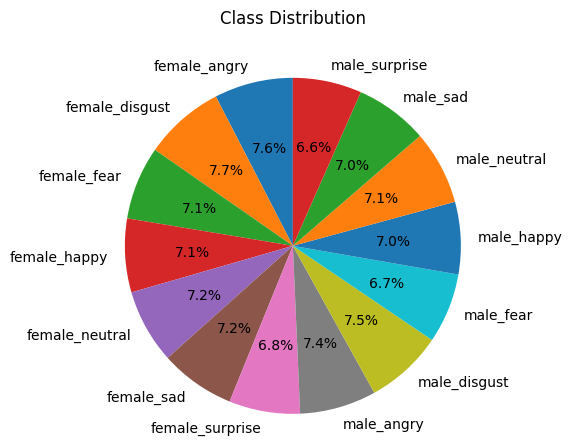

In [17]:
# Displaying the mean variation between the labels
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y = 1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',shadow=False, startangle =90)
ax.axis('equal')
plt.show()
RAV_df.reset_index(inplace=True)

### Feature Visualisation : Utilizing Plots to Understand Features

In [18]:
#Dictionaries to store the Plot Values
signals = {}
fft = {}
fbank = {}
mfccs = {}

In [19]:
#Function to Remove Blank Dead Spaces and Junk data from audio signal to increase relevance
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask. append(True)
        else:
            mask. append(False)
    return mask

In [20]:
#Function performing a Fast Fourier Transform
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

In [21]:
#Functions to Generate Plots
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=True, figsize=(20, 5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x, y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x, y].get_xaxis().set_visible(False)
            axes[x, y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=True, figsize=(20, 5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x, y].set_title(list(signals.keys())[i])
            axes[x, y].plot(freq, Y)
            axes[x, y].get_xaxis().set_visible(False)
            axes[x, y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=True, figsize=(20, 5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x, y].set_title(list(fbank.keys())[i])
            axes[x, y].imshow(list(fbank.values())[i], interpolation='nearest', cmap='hot')
            axes[x, y].get_xaxis().set_visible(False)
            axes[x, y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x, y].set_title(list(mfccs.keys())[i])
            axes[x, y].imshow(list(mfccs.values())[i], interpolation='nearest', cmap='hot')
            axes[x, y].get_xaxis().set_visible(False)
            axes[x, y].get_yaxis().set_visible(False)
            i +=1

In [22]:
#Compiling and Resampling
for c in classes:
    wav_file = str(RAV_df[RAV_df.labels == c].iloc[0,3])
    signal, rate = librosa.load(wav_file, sr=44100)
    mask = envelope(signal, rate, 0.00002)
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt = 26, nfft=1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[c]=mel

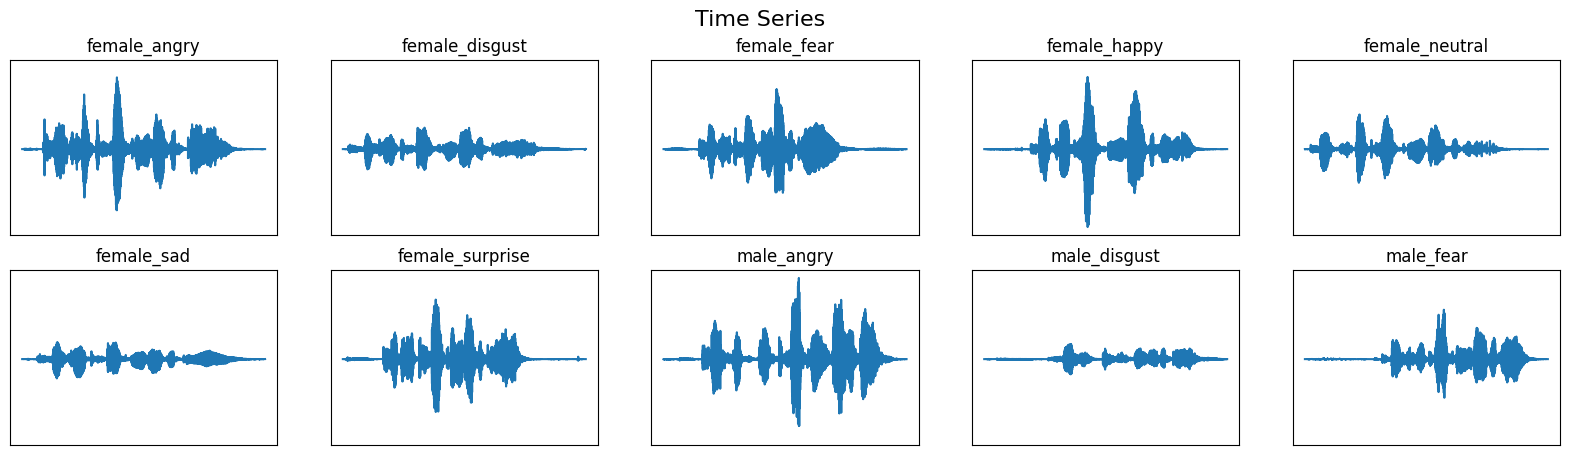

In [23]:
plot_signals(signals)
plt.show()

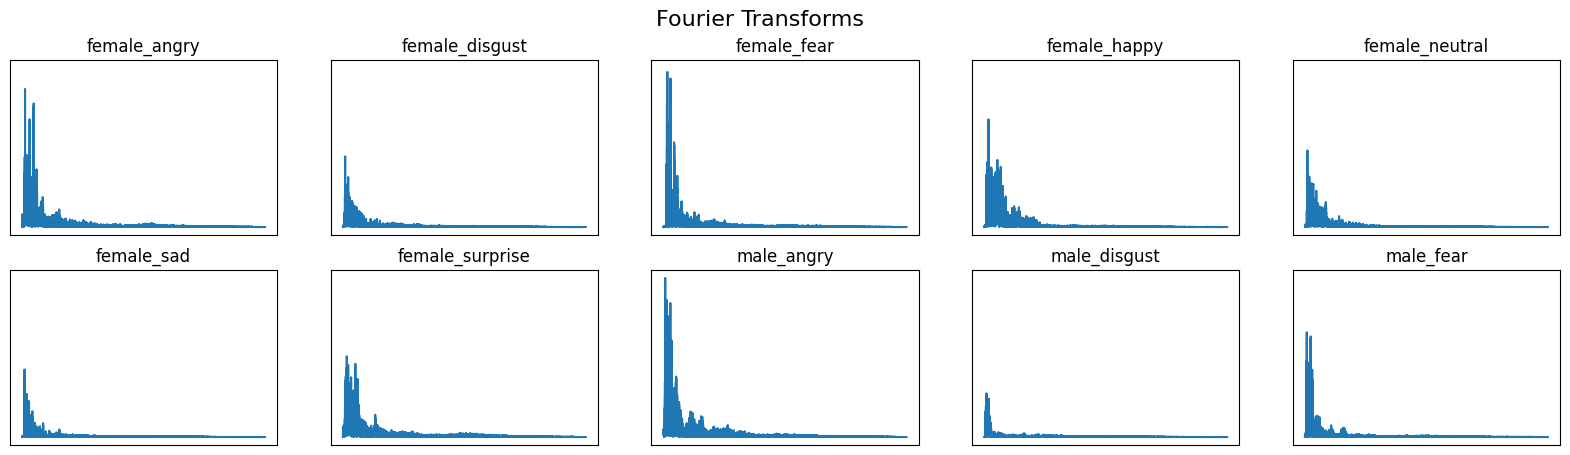

In [24]:
plot_fft(fft)
plt.show()

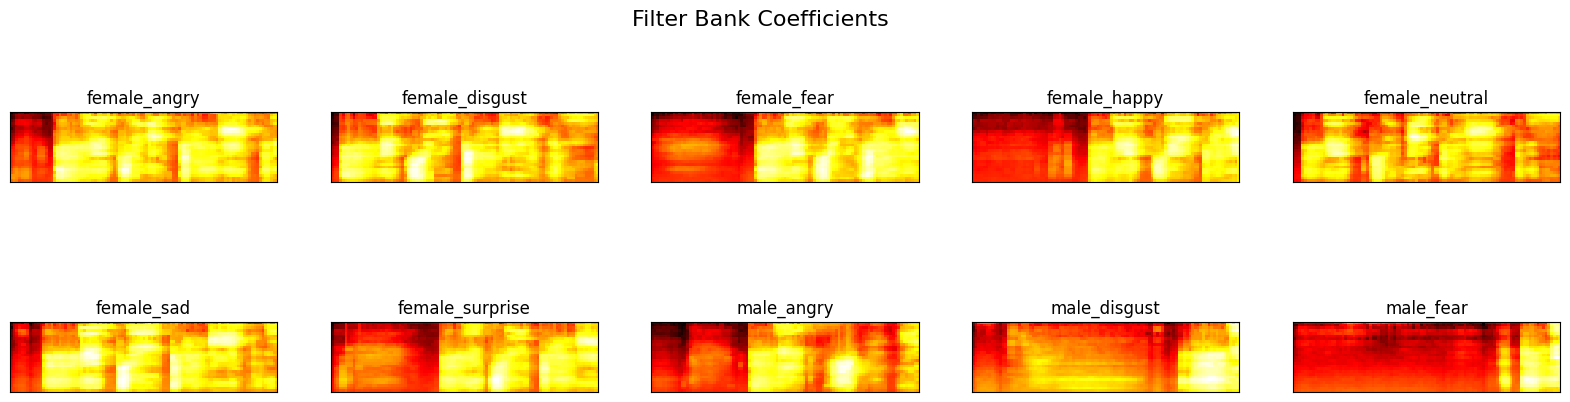

In [25]:
plot_fbank(fbank)
plt.show()

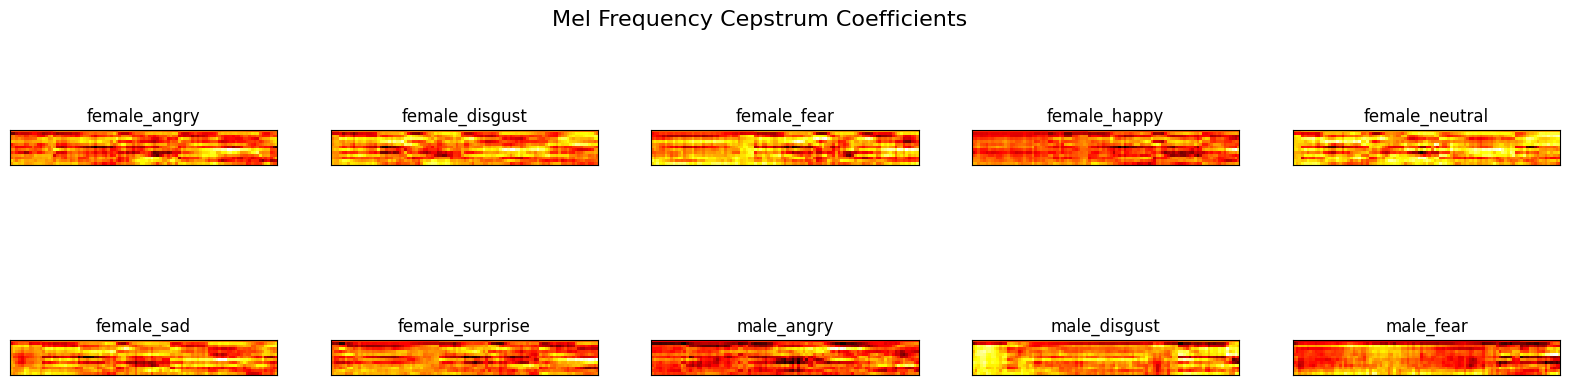

In [26]:
plot_mfccs(mfccs)
plt.show()

### Cleaning and Storing processed audio Data

In [27]:
# Downsampling data to remove unnecesarry high frequencies and removing dead space
if len(os.listdir('Clean'))== 1:
    for f in tqdm(RAV_df.path):
        signal, rate = librosa.load(f, sr=16000)
        mask = envelope(signal, rate, 0.0002)
        wavfile.write(filename='Clean/'+f, rate=rate, data=signal[mask])

100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [00:19<00:00, 75.06it/s]


## Preparing the Processed Data for the CNN Model : Shaping 

### Functions to Extract Features and Generate the Model

In [28]:
def check_data():
    if os.path.isfile('pickles\\conv.p'):
        print('Loading existing data for {} model'.format('conv'))
        with open('pickles\\conv.p', 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [29]:
# Function which shapes the audio
def build_rand_feat():
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p=prob_dist)
        file = np.random.choice(RAV_df[RAV_df.labels==rand_class].index)
        rate, wav = wavfile.read(RAV_df.loc[file].path)
        labels = RAV_df.at[file, 'labels']
        rand_index = np.random.randint(0, wav.shape[0]- 6400)
        sample = wav[rand_index:rand_index+6400]
        X_sample = mfcc(sample, rate, numcep=13, nfilt=26, nfft=512)
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample)
        y.append(classes.index(labels))
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0],  X.shape[1], X.shape[2], 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y, num_classes=14)
    config.data = (X,y)
    
    with open('pickles\\conv.p', 'wb') as handle:
        pickle.dump(config, handle, protocol=2)
    return X, y

In [30]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1),padding='same', input_shape=input_shape))
    model.add(Conv2D(32,(3,3), activation='relu', strides=(1,1), padding= 'same'))
    model.add(Conv2D(64,(3,3), activation='relu', strides=(1,1), padding= 'same'))
    model.add(Conv2D(128,(3,3), activation='relu', strides=(1,1), padding= 'same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0,5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(14, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [31]:
def get_recurrent_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

### Importing Processed Audio Files and converting it into CNN feedable data

In [32]:
# Importing the Processed DataSet
ProcessedAudio = 'Clean/RAVDESS_AudioDataSet'
RAV = ProcessedAudio 

In [33]:
# Create empty lists to store the dataset information
emotion = []
gender = []
path = []
duration = []

# Iterate over each subfolder in the RAVDESS directory
for actor_folder in os.listdir(RAV):
    actor_path = os.path.join(RAV, actor_folder)
    if not os.path.isdir(actor_path):
        continue
    
    # Iterate over each WAV file in the actor's folder
    for wav_file in os.listdir(actor_path):
        if not wav_file.endswith('.wav'):
            continue
        
        # Extract information from the file name
        part = wav_file.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        
        # Determine the gender based on the file name
        if temp % 2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        
        # Store the complete path of the audio file
        file_path = os.path.join(actor_path, wav_file)
        path.append(file_path)
        
        # Calculate the duration of the audio file
        audio, sr = librosa.load(file_path)
        duration.append(round(len(audio) / sr, 2))

# Create a DataFrame with all the collected information
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df], axis=1)
RAV_df.columns = ['gender', 'emotion']
RAV_df['labels'] = RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df, pd.DataFrame(path, columns=['path'])], axis=1)
RAV_df = pd.concat([RAV_df, pd.DataFrame(duration, columns=['duration_seconds'])], axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)

In [34]:
# Processed as noticed by the shorter 'duration_seconds'
RAV_df 

,labels,source,path,duration_seconds
0,male_neutral,RAVDESS,Clean/RAVDESS_AudioDataSet\Actor_01\03-01-01-0...,1.33
1,male_neutral,RAVDESS,Clean/RAVDESS_AudioDataSet\Actor_01\03-01-01-0...,1.37
2,male_neutral,RAVDESS,Clean/RAVDESS_AudioDataSet\Actor_01\03-01-01-0...,1.35
3,male_neutral,RAVDESS,Clean/RAVDESS_AudioDataSet\Actor_01\03-01-01-0...,1.29
4,male_neutral,RAVDESS,Clean/RAVDESS_AudioDataSet\Actor_01\03-01-02-0...,1.61
...,...,...,...,...
1435,female_surprise,RAVDESS,Clean/RAVDESS_AudioDataSet\Actor_24\03-01-08-0...,1.67
1436,female_surprise,RAVDESS,Clean/RAVDESS_AudioDataSet\Actor_24\03-01-08-0...,2.24
1437,female_surprise,RAVDESS,Clean/RAVDESS_AudioDataSet\Actor_24\03-01-08-0...,2.25
1438,female_surprise,RAVDESS,Clean/RAVDESS_AudioDataSet\Actor_24\03-01-08-0...,2.29


In [35]:
classes = list(np.unique(RAV_df.labels))
class_dist = RAV_df.groupby(['labels'])['duration_seconds'].mean()

In [36]:
# Function to create X and Y matrices [Classifying Audio Samples]
n_samples = 2 * int(RAV_df['duration_seconds'].sum()/ 0.1)
prob_dist = class_dist / class_dist.sum()
# Random Sampling
choices = np.random.choice(class_dist.index, p=prob_dist)

In [37]:
prob_dist

labels
female_angry       0.078567
female_disgust     0.077842
female_fear        0.077234
female_happy       0.070787
female_neutral     0.064495
female_sad         0.068981
female_surprise    0.061336
male_angry         0.082349
male_disgust       0.077593
male_fear          0.075704
male_happy         0.070717
male_neutral       0.065025
male_sad           0.068011
male_surprise      0.061358
Name: duration_seconds, dtype: float64

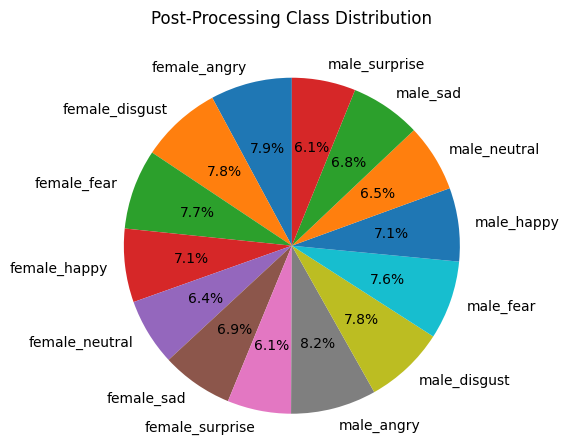

In [38]:
fig, ax = plt.subplots()
ax.set_title('Post-Processing Class Distribution', y = 1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',shadow=False, startangle =90)
ax.axis('equal')
plt.show()

## CNN Model : Evaluating the performance with change of Sample Size and Model

In [39]:
config = Config(mode='conv')
#Best efficents results : 'conv' model using 40 milli secs per sample

In [40]:
# Generating Thousands of Samples and labeling to shape the audio data
if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()
    
elif config.mode == 'time':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_flat), y=y_flat)
class_weight_dict = dict(zip(np.unique(y_flat), class_weights))

checkpoint = ModelCheckpoint('Models\\conv.model', monitor='val_acc', verbose =1, mode = 'max', save_best_only=True, save_weights_only=False, save_freq=14)

model.fit(X , y , epochs=14, batch_size=32, shuffle=True, validation_split=0.7, callbacks=[checkpoint])
model.save('Models/conv.model', save_format='h5')

Loading existing data for conv model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 13, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 39, 13, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 39, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 39, 13, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 6, 128)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 6, 128)        0         
                   

546/546 [==============================] - 73s 134ms/step - loss: 1.5568 - acc: 0.4203 - val_loss: 1.6208 - val_acc: 0.4007
Epoch 4/14
546/546 [==============================] - 72s 133ms/step - loss: 1.4317 - acc: 0.4701 - val_loss: 1.5310 - val_acc: 0.4381
Epoch 5/14
503/546 [==========================>...] - ETA: 4s - loss: 1.3162 - acc: 0.5180WARNING:tensorflow:Can save best model only with val_acc available, skipping.


546/546 [==============================] - 73s 134ms/step - loss: 1.3162 - acc: 0.5189 - val_loss: 1.4823 - val_acc: 0.4550
Epoch 6/14
546/546 [==============================] - 72s 132ms/step - loss: 1.2042 - acc: 0.5629 - val_loss: 1.4432 - val_acc: 0.4705
Epoch 7/14
546/546 [==============================] - 73s 133ms/step - loss: 1.0816 - acc: 0.6061 - val_loss: 1.4756 - val_acc: 0.4803
Epoch 8/14
279/546 [==============>...............] - ETA: 25s - loss: 0.9778 - acc: 0.6443WARNING:tensorflow:Can save best model only with val_acc available, skipping.


546/546 [==============================] - 73s 133ms/step - loss: 0.9888 - acc: 0.6381 - val_loss: 1.4173 - val_acc: 0.5034
Epoch 9/14
546/546 [==============================] - 72s 133ms/step - loss: 0.8876 - acc: 0.6809 - val_loss: 1.4096 - val_acc: 0.5267
Epoch 10/14
546/546 [==============================] - 75s 137ms/step - loss: 0.8060 - acc: 0.7101 - val_loss: 1.4211 - val_acc: 0.5439
Epoch 11/14
 55/546 [==>...........................] - ETA: 52s - loss: 0.6748 - acc: 0.7636WARNING:tensorflow:Can save best model only with val_acc available, skipping.


546/546 [==============================] - 78s 143ms/step - loss: 0.7197 - acc: 0.7432 - val_loss: 1.4857 - val_acc: 0.5447
Epoch 12/14
546/546 [==============================] - 77s 141ms/step - loss: 0.6462 - acc: 0.7715 - val_loss: 1.5056 - val_acc: 0.5443
Epoch 13/14
391/546 [====================>.........] - ETA: 15s - loss: 0.5696 - acc: 0.7948WARNING:tensorflow:Can save best model only with val_acc available, skipping.


546/546 [==============================] - 76s 140ms/step - loss: 0.5802 - acc: 0.7913 - val_loss: 1.5713 - val_acc: 0.5562
Epoch 14/14
546/546 [==============================] - 77s 141ms/step - loss: 0.5267 - acc: 0.8117 - val_loss: 1.6235 - val_acc: 0.5565


## Using the Model on New Inputs : Implementation

In [129]:
import os

def rename_audio_file(file_path):
    # Extract the last two digits from the file name
    file_name = os.path.basename(file_path)
    last_digits = file_name[-6:-4]

    # Construct the new file path with the appended Actor_XX
    actor_number = 'Actor_' + last_digits
    new_file_path = os.path.join('Clean/RAVDESS_AudioDataSet', actor_number, file_name)

    # Rename the file
    return new_file_path

In [142]:
def build_predictions(audio_dir):
    y_true = []
    y_pred = []
    fn_prob = {}

    print('Extracting features from audio')
    for fn in tqdm(os.listdir(audio_dir)):
        rate, wav = wavfile.read(rename_audio_file(fn))
        label = fn2class[rename_audio_file(fn)]
        c = classes.index(label)
        y_prob = []

        for i in range(0, wav.shape[0] - config.step, config.step):
            sample = wav[i:i + config.step]
            X = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
            X = (X - config.min) / (config.max - config.min)
            if config.mode == 'conv':
                X = X.reshape(1, X.shape[0], X.shape[1], 1)
            elif config.mode == 'time':
                X = np.expand_dims(X, axis=0)
            y_hat = model.predict(X)
            y_prob.append(y_hat)
            y_pred.append(np.argmax(y_hat))
            y_true.append(c)
        fn_prob[rename_audio_file(fn)] = np.mean(y_prob, axis=0).flatten()

    return y_true, y_pred, fn_prob

classes = list(np.unique(RAV_df.labels))
fn2class = dict(zip(RAV_df.path, RAV_df.labels))
p_path = 'pickles/conv.p'

with open(p_path, 'rb') as handle:
    config = pickle.load(handle)
    
model = load_model(config.model_path)

y_true, y_pred, fn_prob = build_predictions('pred_data')
acc_score = accuracy_score(y_true=y_true, y_pred=y_pred)

y_probs = []
for i, row in RAV_df.iterrows():
    y_prob = fn_prob[row.path]
    y_probs.append(y_prob)
    for c, p in zip(classes, y_prob):
        RAV_df.at[i, c] = p
        
y_pred = [classes[np.argmax(y)] for y in y_probs]        
RAV_df['y_pred'] = y_pred

RAV_df.to_csv('predictions.csv', index= False)

Extracting features from audio


  0%|                                                                                         | 0/1440 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|                                                                                 | 1/1440 [00:00<05:01,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


  0%|                                                                                 | 2/1440 [00:00<05:09,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


  0%|▏                                                                                | 3/1440 [00:00<05:05,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


  0%|▏                                                                                | 4/1440 [00:00<04:35,  5.21it/s]

1/1 [==============================] - 0s 20ms/step


  0%|▎                                                                                | 5/1440 [00:01<04:42,  5.09it/s]

1/1 [==============================] - 0s 24ms/step


  0%|▎                                                                                | 6/1440 [00:01<04:37,  5.17it/s]

1/1 [==============================] - 0s 27ms/step


  0%|▍                                                                                | 7/1440 [00:01<05:49,  4.10it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▍                                                                                | 8/1440 [00:01<05:28,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▌                                                                                | 9/1440 [00:02<05:46,  4.14it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▌                                                                               | 10/1440 [00:02<05:38,  4.23it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▌                                                                               | 11/1440 [00:02<05:17,  4.50it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▋                                                                               | 12/1440 [00:02<05:19,  4.47it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▋                                                                               | 13/1440 [00:02<05:10,  4.60it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▊                                                                               | 14/1440 [00:03<04:56,  4.81it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▊                                                                               | 15/1440 [00:03<04:49,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▉                                                                               | 16/1440 [00:03<05:02,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▉                                                                               | 17/1440 [00:03<05:01,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


  1%|█                                                                               | 18/1440 [00:03<05:00,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


  1%|█                                                                               | 19/1440 [00:04<04:35,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


  1%|█                                                                               | 20/1440 [00:04<04:19,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


  1%|█▏                                                                              | 21/1440 [00:04<04:34,  5.16it/s]

1/1 [==============================] - 0s 21ms/step


  2%|█▏                                                                              | 22/1440 [00:04<04:40,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


  2%|█▎                                                                              | 23/1440 [00:04<04:48,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


  2%|█▎                                                                              | 24/1440 [00:05<04:48,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


  2%|█▍                                                                              | 25/1440 [00:05<04:35,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


  2%|█▍                                                                              | 26/1440 [00:05<04:42,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


  2%|█▌                                                                              | 27/1440 [00:06<08:57,  2.63it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█▌                                                                              | 28/1440 [00:06<07:28,  3.15it/s]

1/1 [==============================] - 0s 22ms/step


  2%|█▌                                                                              | 29/1440 [00:06<06:44,  3.49it/s]

1/1 [==============================] - 0s 22ms/step


  2%|█▋                                                                              | 30/1440 [00:06<06:10,  3.81it/s]

1/1 [==============================] - 0s 20ms/step


  2%|█▋                                                                              | 31/1440 [00:07<06:10,  3.80it/s]

1/1 [==============================] - 0s 22ms/step


  2%|█▊                                                                              | 32/1440 [00:07<05:52,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


  2%|█▊                                                                              | 33/1440 [00:07<05:12,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


  2%|█▉                                                                              | 34/1440 [00:07<05:27,  4.29it/s]

1/1 [==============================] - 0s 24ms/step


  2%|█▉                                                                              | 35/1440 [00:07<04:57,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


  2%|██                                                                              | 36/1440 [00:08<04:57,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


  3%|██                                                                              | 37/1440 [00:08<04:38,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


  3%|██                                                                              | 38/1440 [00:08<04:38,  5.04it/s]

1/1 [==============================] - 0s 21ms/step


  3%|██▏                                                                             | 39/1440 [00:08<04:22,  5.33it/s]

1/1 [==============================] - 0s 22ms/step


  3%|██▏                                                                             | 40/1440 [00:08<04:34,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


  3%|██▎                                                                             | 41/1440 [00:08<04:18,  5.40it/s]

1/1 [==============================] - 0s 23ms/step


  3%|██▎                                                                             | 42/1440 [00:09<04:30,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


  3%|██▍                                                                             | 43/1440 [00:09<04:16,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


  3%|██▍                                                                             | 44/1440 [00:09<04:28,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


  3%|██▌                                                                             | 45/1440 [00:09<04:36,  5.04it/s]

1/1 [==============================] - 0s 22ms/step


  3%|██▌                                                                             | 46/1440 [00:09<04:20,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


  3%|██▌                                                                             | 47/1440 [00:10<04:33,  5.10it/s]

1/1 [==============================] - 0s 24ms/step


  3%|██▋                                                                             | 48/1440 [00:10<04:43,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


  3%|██▋                                                                             | 49/1440 [00:10<04:25,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


  3%|██▊                                                                             | 50/1440 [00:10<04:39,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


  4%|██▊                                                                             | 51/1440 [00:10<04:40,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


  4%|██▉                                                                             | 52/1440 [00:11<04:21,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


  4%|██▉                                                                             | 53/1440 [00:11<04:16,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


  4%|███                                                                             | 54/1440 [00:11<04:06,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


  4%|███                                                                             | 55/1440 [00:11<04:45,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


  4%|███                                                                             | 56/1440 [00:11<04:49,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


  4%|███▏                                                                            | 57/1440 [00:12<04:28,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


  4%|███▏                                                                            | 58/1440 [00:12<05:01,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


  4%|███▎                                                                            | 59/1440 [00:12<04:38,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


  4%|███▎                                                                            | 60/1440 [00:12<04:40,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


  4%|███▍                                                                            | 61/1440 [00:12<04:21,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


  4%|███▍                                                                            | 62/1440 [00:13<04:10,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


  4%|███▌                                                                            | 63/1440 [00:13<03:59,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


  4%|███▌                                                                            | 64/1440 [00:13<04:17,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


  5%|███▌                                                                            | 65/1440 [00:13<04:27,  5.15it/s]

1/1 [==============================] - 0s 21ms/step


  5%|███▋                                                                            | 66/1440 [00:13<04:34,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


  5%|███▋                                                                            | 67/1440 [00:14<04:15,  5.37it/s]

1/1 [==============================] - 0s 21ms/step


  5%|███▊                                                                            | 68/1440 [00:14<04:05,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


  5%|███▊                                                                            | 69/1440 [00:14<04:21,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


  5%|███▉                                                                            | 70/1440 [00:14<04:27,  5.11it/s]

1/1 [==============================] - 0s 20ms/step


  5%|███▉                                                                            | 71/1440 [00:14<04:31,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


  5%|████                                                                            | 72/1440 [00:15<04:34,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


  5%|████                                                                            | 73/1440 [00:15<04:19,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


  5%|████                                                                            | 74/1440 [00:15<04:26,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


  5%|████▏                                                                           | 75/1440 [00:15<04:27,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


  5%|████▏                                                                           | 76/1440 [00:15<04:10,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


  5%|████▎                                                                           | 77/1440 [00:15<04:17,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


  5%|████▎                                                                           | 78/1440 [00:16<04:05,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


  5%|████▍                                                                           | 79/1440 [00:16<04:32,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


  6%|████▍                                                                           | 80/1440 [00:16<04:39,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


  6%|████▌                                                                           | 81/1440 [00:16<04:18,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


  6%|████▌                                                                           | 82/1440 [00:16<04:23,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


  6%|████▌                                                                           | 83/1440 [00:17<04:32,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


  6%|████▋                                                                           | 84/1440 [00:17<04:34,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


  6%|████▋                                                                           | 85/1440 [00:17<04:16,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


  6%|████▊                                                                           | 86/1440 [00:17<04:02,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


  6%|████▊                                                                           | 87/1440 [00:17<03:51,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


  6%|████▉                                                                           | 88/1440 [00:18<04:04,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


  6%|████▉                                                                           | 89/1440 [00:18<03:54,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


  6%|█████                                                                           | 90/1440 [00:18<03:46,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


  6%|█████                                                                           | 91/1440 [00:18<03:45,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


  6%|█████                                                                           | 92/1440 [00:18<03:59,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


  6%|█████▏                                                                          | 93/1440 [00:18<04:10,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


  7%|█████▏                                                                          | 94/1440 [00:19<04:16,  5.24it/s]

1/1 [==============================] - 0s 20ms/step


  7%|█████▎                                                                          | 95/1440 [00:19<04:22,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


  7%|█████▎                                                                          | 96/1440 [00:19<04:29,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


  7%|█████▍                                                                          | 97/1440 [00:19<04:29,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


  7%|█████▍                                                                          | 98/1440 [00:19<04:32,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


  7%|█████▌                                                                          | 99/1440 [00:20<04:51,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


  7%|█████▍                                                                         | 100/1440 [00:20<04:51,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


  7%|█████▌                                                                         | 101/1440 [00:20<05:09,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


  7%|█████▌                                                                         | 102/1440 [00:20<05:22,  4.15it/s]

1/1 [==============================] - 0s 22ms/step


  7%|█████▋                                                                         | 103/1440 [00:21<05:12,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


  7%|█████▋                                                                         | 104/1440 [00:21<04:58,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


  7%|█████▊                                                                         | 105/1440 [00:21<04:32,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


  7%|█████▊                                                                         | 106/1440 [00:21<04:54,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


  7%|█████▊                                                                         | 107/1440 [00:21<04:27,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


  8%|█████▉                                                                         | 108/1440 [00:22<04:48,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


  8%|█████▉                                                                         | 109/1440 [00:22<04:22,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


  8%|██████                                                                         | 110/1440 [00:22<04:28,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


  8%|██████                                                                         | 111/1440 [00:22<04:30,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


  8%|██████▏                                                                        | 112/1440 [00:22<04:29,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


  8%|██████▏                                                                        | 113/1440 [00:23<04:09,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


  8%|██████▎                                                                        | 114/1440 [00:23<04:16,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


  8%|██████▎                                                                        | 115/1440 [00:23<04:21,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


  8%|██████▎                                                                        | 116/1440 [00:23<04:23,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


  8%|██████▍                                                                        | 117/1440 [00:23<04:45,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


  8%|██████▍                                                                        | 118/1440 [00:24<04:40,  4.71it/s]

1/1 [==============================] - 0s 22ms/step


  8%|██████▌                                                                        | 119/1440 [00:24<04:37,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


  8%|██████▌                                                                        | 120/1440 [00:24<04:36,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


  8%|██████▋                                                                        | 121/1440 [00:24<04:33,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


  8%|██████▋                                                                        | 122/1440 [00:25<04:52,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


  9%|██████▋                                                                        | 123/1440 [00:25<05:08,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


  9%|██████▊                                                                        | 124/1440 [00:25<04:59,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


  9%|██████▊                                                                        | 125/1440 [00:25<04:51,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


  9%|██████▉                                                                        | 126/1440 [00:26<05:21,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


  9%|██████▉                                                                        | 127/1440 [00:26<05:07,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


  9%|███████                                                                        | 128/1440 [00:26<04:35,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


  9%|███████                                                                        | 129/1440 [00:26<04:18,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


  9%|███████▏                                                                       | 130/1440 [00:26<04:40,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


  9%|███████▏                                                                       | 131/1440 [00:27<04:35,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


  9%|███████▏                                                                       | 132/1440 [00:27<04:33,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


  9%|███████▎                                                                       | 133/1440 [00:27<04:14,  5.14it/s]

1/1 [==============================] - 0s 21ms/step


  9%|███████▎                                                                       | 134/1440 [00:27<04:17,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


  9%|███████▍                                                                       | 135/1440 [00:27<04:19,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


  9%|███████▍                                                                       | 136/1440 [00:28<04:41,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 10%|███████▌                                                                       | 137/1440 [00:28<04:16,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


 10%|███████▌                                                                       | 138/1440 [00:28<04:21,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


 10%|███████▋                                                                       | 139/1440 [00:28<04:25,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 10%|███████▋                                                                       | 140/1440 [00:28<04:06,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


 10%|███████▋                                                                       | 141/1440 [00:29<04:32,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 10%|███████▊                                                                       | 142/1440 [00:29<04:30,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 10%|███████▊                                                                       | 143/1440 [00:29<04:27,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 10%|███████▉                                                                       | 144/1440 [00:29<04:29,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 10%|███████▉                                                                       | 145/1440 [00:29<04:26,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 10%|████████                                                                       | 146/1440 [00:30<04:25,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 10%|████████                                                                       | 147/1440 [00:30<04:45,  4.53it/s]

1/1 [==============================] - 0s 24ms/step


 10%|████████                                                                       | 148/1440 [00:30<04:44,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 10%|████████▏                                                                      | 149/1440 [00:30<05:00,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 10%|████████▏                                                                      | 150/1440 [00:31<05:27,  3.93it/s]

1/1 [==============================] - 0s 21ms/step


 10%|████████▎                                                                      | 151/1440 [00:31<05:36,  3.83it/s]

1/1 [==============================] - 0s 21ms/step


 11%|████████▎                                                                      | 152/1440 [00:31<04:55,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


 11%|████████▍                                                                      | 153/1440 [00:31<04:45,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 11%|████████▍                                                                      | 154/1440 [00:32<04:59,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 11%|████████▌                                                                      | 155/1440 [00:32<04:28,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 11%|████████▌                                                                      | 156/1440 [00:32<04:26,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 11%|████████▌                                                                      | 157/1440 [00:32<04:07,  5.18it/s]

1/1 [==============================] - 0s 24ms/step


 11%|████████▋                                                                      | 158/1440 [00:32<03:58,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


 11%|████████▋                                                                      | 159/1440 [00:33<04:51,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 11%|████████▊                                                                      | 160/1440 [00:33<04:41,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 11%|████████▊                                                                      | 161/1440 [00:33<04:34,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 11%|████████▉                                                                      | 162/1440 [00:33<04:30,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 11%|████████▉                                                                      | 163/1440 [00:33<04:08,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


 11%|████████▉                                                                      | 164/1440 [00:33<03:53,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█████████                                                                      | 165/1440 [00:34<04:01,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█████████                                                                      | 166/1440 [00:34<04:05,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█████████▏                                                                     | 167/1440 [00:34<04:09,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█████████▏                                                                     | 168/1440 [00:34<04:20,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█████████▎                                                                     | 169/1440 [00:34<03:57,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█████████▎                                                                     | 170/1440 [00:35<04:22,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█████████▍                                                                     | 171/1440 [00:35<05:01,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█████████▍                                                                     | 172/1440 [00:35<04:48,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█████████▍                                                                     | 173/1440 [00:35<04:58,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█████████▌                                                                     | 174/1440 [00:36<05:03,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█████████▌                                                                     | 175/1440 [00:36<04:49,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█████████▋                                                                     | 176/1440 [00:36<04:24,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█████████▋                                                                     | 177/1440 [00:36<04:23,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█████████▊                                                                     | 178/1440 [00:36<04:20,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█████████▊                                                                     | 179/1440 [00:37<04:18,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█████████▉                                                                     | 180/1440 [00:37<04:20,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█████████▉                                                                     | 181/1440 [00:37<03:40,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█████████▉                                                                     | 182/1440 [00:37<03:34,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 13%|██████████                                                                     | 183/1440 [00:37<03:45,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 13%|██████████                                                                     | 184/1440 [00:38<03:51,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


 13%|██████████▏                                                                    | 185/1440 [00:38<03:59,  5.23it/s]

1/1 [==============================] - 0s 21ms/step


 13%|██████████▏                                                                    | 186/1440 [00:38<04:02,  5.17it/s]

1/1 [==============================] - 0s 23ms/step


 13%|██████████▎                                                                    | 187/1440 [00:38<04:13,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 13%|██████████▎                                                                    | 188/1440 [00:38<03:55,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 13%|██████████▎                                                                    | 189/1440 [00:39<04:20,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 13%|██████████▍                                                                    | 190/1440 [00:39<04:18,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 13%|██████████▍                                                                    | 191/1440 [00:39<04:16,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


 13%|██████████▌                                                                    | 192/1440 [00:39<04:16,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 13%|██████████▌                                                                    | 193/1440 [00:39<04:17,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 13%|██████████▋                                                                    | 194/1440 [00:40<04:34,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 14%|██████████▋                                                                    | 195/1440 [00:40<05:43,  3.63it/s]

1/1 [==============================] - 0s 20ms/step


 14%|██████████▊                                                                    | 196/1440 [00:40<05:39,  3.67it/s]

1/1 [==============================] - 0s 21ms/step


 14%|██████████▊                                                                    | 197/1440 [00:41<05:54,  3.50it/s]

1/1 [==============================] - 0s 21ms/step


 14%|██████████▊                                                                    | 198/1440 [00:41<06:05,  3.40it/s]

1/1 [==============================] - 0s 20ms/step


 14%|██████████▉                                                                    | 199/1440 [00:41<06:31,  3.17it/s]

1/1 [==============================] - 0s 21ms/step


 14%|██████████▉                                                                    | 200/1440 [00:42<05:54,  3.49it/s]

1/1 [==============================] - 0s 20ms/step


 14%|███████████                                                                    | 201/1440 [00:42<05:04,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 14%|███████████                                                                    | 202/1440 [00:42<05:08,  4.02it/s]

1/1 [==============================] - 0s 23ms/step


 14%|███████████▏                                                                   | 203/1440 [00:42<05:00,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 14%|███████████▏                                                                   | 204/1440 [00:42<05:05,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 14%|███████████▏                                                                   | 205/1440 [00:43<04:29,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 14%|███████████▎                                                                   | 206/1440 [00:43<04:23,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 14%|███████████▎                                                                   | 207/1440 [00:43<04:18,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


 14%|███████████▍                                                                   | 208/1440 [00:43<04:35,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 15%|███████████▍                                                                   | 209/1440 [00:43<04:30,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 15%|███████████▌                                                                   | 210/1440 [00:44<04:24,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 15%|███████████▌                                                                   | 211/1440 [00:44<04:58,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 15%|███████████▋                                                                   | 212/1440 [00:44<04:44,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 15%|███████████▋                                                                   | 213/1440 [00:44<04:53,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 15%|███████████▋                                                                   | 214/1440 [00:45<04:40,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 15%|███████████▊                                                                   | 215/1440 [00:45<04:48,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 15%|███████████▊                                                                   | 216/1440 [00:45<04:57,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 15%|███████████▉                                                                   | 217/1440 [00:45<05:13,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


 15%|███████████▉                                                                   | 218/1440 [00:46<05:14,  3.88it/s]

1/1 [==============================] - 0s 22ms/step


 15%|████████████                                                                   | 219/1440 [00:46<05:32,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 15%|████████████                                                                   | 220/1440 [00:46<05:18,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


 15%|████████████                                                                   | 221/1440 [00:46<04:55,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 15%|████████████▏                                                                  | 222/1440 [00:47<05:17,  3.84it/s]

1/1 [==============================] - 0s 20ms/step


 15%|████████████▏                                                                  | 223/1440 [00:47<05:11,  3.90it/s]

1/1 [==============================] - 0s 22ms/step


 16%|████████████▎                                                                  | 224/1440 [00:47<04:54,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 16%|████████████▎                                                                  | 225/1440 [00:47<04:45,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 16%|████████████▍                                                                  | 226/1440 [00:48<04:50,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 16%|████████████▍                                                                  | 227/1440 [00:48<04:39,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 16%|████████████▌                                                                  | 228/1440 [00:48<04:26,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 16%|████████████▌                                                                  | 229/1440 [00:48<04:03,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


 16%|████████████▌                                                                  | 230/1440 [00:48<04:04,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 16%|████████████▋                                                                  | 231/1440 [00:49<04:23,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 16%|████████████▋                                                                  | 232/1440 [00:49<04:35,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 16%|████████████▊                                                                  | 233/1440 [00:49<04:30,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 16%|████████████▊                                                                  | 234/1440 [00:49<04:25,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 16%|████████████▉                                                                  | 235/1440 [00:50<04:42,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 16%|████████████▉                                                                  | 236/1440 [00:50<04:31,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█████████████                                                                  | 237/1440 [00:50<05:00,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█████████████                                                                  | 238/1440 [00:50<04:47,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█████████████                                                                  | 239/1440 [00:51<04:52,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█████████████▏                                                                 | 240/1440 [00:51<04:54,  4.07it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█████████████▏                                                                 | 241/1440 [00:51<05:01,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█████████████▎                                                                 | 242/1440 [00:51<05:06,  3.91it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█████████████▎                                                                 | 243/1440 [00:52<05:46,  3.45it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█████████████▍                                                                 | 244/1440 [00:52<05:55,  3.37it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█████████████▍                                                                 | 245/1440 [00:52<05:58,  3.33it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█████████████▍                                                                 | 246/1440 [00:53<06:03,  3.29it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█████████████▌                                                                 | 247/1440 [00:53<06:05,  3.26it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█████████████▌                                                                 | 248/1440 [00:53<05:28,  3.62it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█████████████▋                                                                 | 249/1440 [00:53<05:21,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█████████████▋                                                                 | 250/1440 [00:54<05:17,  3.74it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█████████████▊                                                                 | 251/1440 [00:54<04:53,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█████████████▊                                                                 | 252/1440 [00:54<04:39,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█████████████▉                                                                 | 253/1440 [00:54<03:55,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█████████████▉                                                                 | 254/1440 [00:54<03:59,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█████████████▉                                                                 | 255/1440 [00:55<04:34,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 18%|██████████████                                                                 | 256/1440 [00:55<04:21,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 18%|██████████████                                                                 | 257/1440 [00:55<04:14,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 18%|██████████████▏                                                                | 258/1440 [00:55<04:12,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 18%|██████████████▏                                                                | 259/1440 [00:56<04:43,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 18%|██████████████▎                                                                | 260/1440 [00:56<04:13,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 18%|██████████████▎                                                                | 261/1440 [00:56<04:26,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 18%|██████████████▎                                                                | 262/1440 [00:56<04:19,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 18%|██████████████▍                                                                | 263/1440 [00:56<04:13,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 18%|██████████████▍                                                                | 264/1440 [00:57<04:26,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 18%|██████████████▌                                                                | 265/1440 [00:57<04:36,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


 18%|██████████████▌                                                                | 266/1440 [00:57<04:45,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 19%|██████████████▋                                                                | 267/1440 [00:58<05:26,  3.59it/s]

1/1 [==============================] - 0s 22ms/step


 19%|██████████████▋                                                                | 268/1440 [00:58<05:17,  3.69it/s]

1/1 [==============================] - 0s 20ms/step


 19%|██████████████▊                                                                | 269/1440 [00:58<05:15,  3.71it/s]

1/1 [==============================] - 0s 20ms/step


 19%|██████████████▊                                                                | 270/1440 [00:59<05:52,  3.32it/s]

1/1 [==============================] - 0s 19ms/step


 19%|██████████████▊                                                                | 271/1440 [00:59<05:53,  3.31it/s]

1/1 [==============================] - 0s 20ms/step


 19%|██████████████▉                                                                | 272/1440 [00:59<05:16,  3.68it/s]

1/1 [==============================] - 0s 20ms/step


 19%|██████████████▉                                                                | 273/1440 [00:59<04:53,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 19%|███████████████                                                                | 274/1440 [00:59<04:57,  3.92it/s]

1/1 [==============================] - 0s 20ms/step


 19%|███████████████                                                                | 275/1440 [01:00<04:54,  3.95it/s]

1/1 [==============================] - 0s 21ms/step


 19%|███████████████▏                                                               | 276/1440 [01:00<04:38,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 19%|███████████████▏                                                               | 277/1440 [01:00<03:50,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


 19%|███████████████▎                                                               | 278/1440 [01:00<03:51,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 19%|███████████████▎                                                               | 279/1440 [01:00<04:13,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 19%|███████████████▎                                                               | 280/1440 [01:01<04:06,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 20%|███████████████▍                                                               | 281/1440 [01:01<03:44,  5.16it/s]

1/1 [==============================] - 0s 21ms/step


 20%|███████████████▍                                                               | 282/1440 [01:01<03:47,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


 20%|███████████████▌                                                               | 283/1440 [01:01<04:08,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 20%|███████████████▌                                                               | 284/1440 [01:02<04:05,  4.71it/s]

1/1 [==============================] - 0s 22ms/step


 20%|███████████████▋                                                               | 285/1440 [01:02<04:18,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 20%|███████████████▋                                                               | 286/1440 [01:02<04:10,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 20%|███████████████▋                                                               | 287/1440 [01:02<04:22,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 20%|███████████████▊                                                               | 288/1440 [01:02<04:36,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 20%|███████████████▊                                                               | 289/1440 [01:03<04:23,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 20%|███████████████▉                                                               | 290/1440 [01:03<04:15,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 20%|███████████████▉                                                               | 291/1440 [01:03<04:25,  4.33it/s]

1/1 [==============================] - 0s 23ms/step


 20%|████████████████                                                               | 292/1440 [01:03<04:00,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 20%|████████████████                                                               | 293/1440 [01:04<04:14,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 20%|████████████████▏                                                              | 294/1440 [01:04<04:08,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 20%|████████████████▏                                                              | 295/1440 [01:04<04:03,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 21%|████████████████▏                                                              | 296/1440 [01:04<04:02,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 21%|████████████████▎                                                              | 297/1440 [01:04<04:00,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 21%|████████████████▎                                                              | 298/1440 [01:05<03:58,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 21%|████████████████▍                                                              | 299/1440 [01:05<03:37,  5.24it/s]

1/1 [==============================] - 0s 20ms/step


 21%|████████████████▍                                                              | 300/1440 [01:05<03:42,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


 21%|████████████████▌                                                              | 301/1440 [01:05<03:27,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 21%|████████████████▌                                                              | 302/1440 [01:05<03:51,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


 21%|████████████████▌                                                              | 303/1440 [01:06<03:36,  5.25it/s]

1/1 [==============================] - 0s 21ms/step


 21%|████████████████▋                                                              | 304/1440 [01:06<03:39,  5.17it/s]

1/1 [==============================] - 0s 21ms/step


 21%|████████████████▋                                                              | 305/1440 [01:06<03:25,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 21%|████████████████▊                                                              | 306/1440 [01:06<03:16,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


 21%|████████████████▊                                                              | 307/1440 [01:06<03:44,  5.05it/s]

1/1 [==============================] - 0s 20ms/step


 21%|████████████████▉                                                              | 308/1440 [01:06<03:51,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 21%|████████████████▉                                                              | 309/1440 [01:07<03:53,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 22%|█████████████████                                                              | 310/1440 [01:07<03:52,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 22%|█████████████████                                                              | 311/1440 [01:07<03:34,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


 22%|█████████████████                                                              | 312/1440 [01:07<03:38,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


 22%|█████████████████▏                                                             | 313/1440 [01:07<03:40,  5.11it/s]

1/1 [==============================] - 0s 20ms/step


 22%|█████████████████▏                                                             | 314/1440 [01:08<03:43,  5.05it/s]

1/1 [==============================] - 0s 21ms/step


 22%|█████████████████▎                                                             | 315/1440 [01:08<04:20,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 22%|█████████████████▎                                                             | 316/1440 [01:08<04:11,  4.48it/s]

1/1 [==============================] - 0s 23ms/step


 22%|█████████████████▍                                                             | 317/1440 [01:08<03:50,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 22%|█████████████████▍                                                             | 318/1440 [01:09<04:26,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 22%|█████████████████▌                                                             | 319/1440 [01:09<04:19,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 22%|█████████████████▌                                                             | 320/1440 [01:09<04:09,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 22%|█████████████████▌                                                             | 321/1440 [01:09<04:02,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 22%|█████████████████▋                                                             | 322/1440 [01:09<04:01,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 22%|█████████████████▋                                                             | 323/1440 [01:10<03:40,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


 22%|█████████████████▊                                                             | 324/1440 [01:10<03:42,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 23%|█████████████████▊                                                             | 325/1440 [01:10<03:28,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


 23%|█████████████████▉                                                             | 326/1440 [01:10<03:33,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


 23%|█████████████████▉                                                             | 327/1440 [01:10<03:46,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 23%|█████████████████▉                                                             | 328/1440 [01:11<03:46,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██████████████████                                                             | 329/1440 [01:11<03:28,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██████████████████                                                             | 330/1440 [01:11<03:16,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██████████████████▏                                                            | 331/1440 [01:11<03:57,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██████████████████▏                                                            | 332/1440 [01:11<03:56,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██████████████████▎                                                            | 333/1440 [01:12<03:51,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██████████████████▎                                                            | 334/1440 [01:12<03:49,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██████████████████▍                                                            | 335/1440 [01:12<03:30,  5.25it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██████████████████▍                                                            | 336/1440 [01:12<03:34,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██████████████████▍                                                            | 337/1440 [01:12<03:20,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██████████████████▌                                                            | 338/1440 [01:13<03:29,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██████████████████▌                                                            | 339/1440 [01:13<03:33,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██████████████████▋                                                            | 340/1440 [01:13<03:34,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██████████████████▋                                                            | 341/1440 [01:13<03:18,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██████████████████▊                                                            | 342/1440 [01:13<03:26,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██████████████████▊                                                            | 343/1440 [01:14<03:31,  5.18it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██████████████████▊                                                            | 344/1440 [01:14<03:19,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██████████████████▉                                                            | 345/1440 [01:14<03:09,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██████████████████▉                                                            | 346/1440 [01:14<03:37,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 24%|███████████████████                                                            | 347/1440 [01:14<03:23,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 24%|███████████████████                                                            | 348/1440 [01:14<03:34,  5.09it/s]

1/1 [==============================] - 0s 22ms/step


 24%|███████████████████▏                                                           | 349/1440 [01:15<03:21,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


 24%|███████████████████▏                                                           | 350/1440 [01:15<03:11,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 24%|███████████████████▎                                                           | 351/1440 [01:15<03:18,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 24%|███████████████████▎                                                           | 352/1440 [01:15<03:26,  5.28it/s]

1/1 [==============================] - 0s 20ms/step


 25%|███████████████████▎                                                           | 353/1440 [01:15<03:13,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 25%|███████████████████▍                                                           | 354/1440 [01:16<03:22,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


 25%|███████████████████▍                                                           | 355/1440 [01:16<03:28,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 25%|███████████████████▌                                                           | 356/1440 [01:16<03:31,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 25%|███████████████████▌                                                           | 357/1440 [01:16<03:50,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 25%|███████████████████▋                                                           | 358/1440 [01:16<03:52,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 25%|███████████████████▋                                                           | 359/1440 [01:17<03:32,  5.08it/s]

1/1 [==============================] - 0s 20ms/step


 25%|███████████████████▊                                                           | 360/1440 [01:17<03:18,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 25%|███████████████████▊                                                           | 361/1440 [01:17<03:28,  5.17it/s]

1/1 [==============================] - 0s 21ms/step


 25%|███████████████████▊                                                           | 362/1440 [01:17<03:32,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


 25%|███████████████████▉                                                           | 363/1440 [01:17<03:39,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


 25%|███████████████████▉                                                           | 364/1440 [01:18<03:24,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


 25%|████████████████████                                                           | 365/1440 [01:18<03:42,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


 25%|████████████████████                                                           | 366/1440 [01:18<03:42,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 25%|████████████████████▏                                                          | 367/1440 [01:18<03:43,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 26%|████████████████████▏                                                          | 368/1440 [01:18<03:24,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 26%|████████████████████▏                                                          | 369/1440 [01:19<03:17,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 26%|████████████████████▎                                                          | 370/1440 [01:19<03:21,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 26%|████████████████████▎                                                          | 371/1440 [01:19<03:10,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 26%|████████████████████▍                                                          | 372/1440 [01:19<03:19,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


 26%|████████████████████▍                                                          | 373/1440 [01:19<03:08,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


 26%|████████████████████▌                                                          | 374/1440 [01:19<02:59,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 26%|████████████████████▌                                                          | 375/1440 [01:20<02:55,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 26%|████████████████████▋                                                          | 376/1440 [01:20<03:07,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 26%|████████████████████▋                                                          | 377/1440 [01:20<03:30,  5.05it/s]

1/1 [==============================] - 0s 21ms/step


 26%|████████████████████▋                                                          | 378/1440 [01:20<03:31,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


 26%|████████████████████▊                                                          | 379/1440 [01:20<03:51,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 26%|████████████████████▊                                                          | 380/1440 [01:21<03:29,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 26%|████████████████████▉                                                          | 381/1440 [01:21<03:30,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


 27%|████████████████████▉                                                          | 382/1440 [01:21<03:31,  5.01it/s]

1/1 [==============================] - 0s 21ms/step


 27%|█████████████████████                                                          | 383/1440 [01:21<03:16,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 27%|█████████████████████                                                          | 384/1440 [01:21<03:23,  5.20it/s]

1/1 [==============================] - 0s 21ms/step


 27%|█████████████████████                                                          | 385/1440 [01:22<03:28,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


 27%|█████████████████████▏                                                         | 386/1440 [01:22<03:50,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 27%|█████████████████████▏                                                         | 387/1440 [01:22<04:55,  3.56it/s]

1/1 [==============================] - 0s 22ms/step


 27%|█████████████████████▎                                                         | 388/1440 [01:23<04:57,  3.54it/s]

1/1 [==============================] - 0s 20ms/step


 27%|█████████████████████▎                                                         | 389/1440 [01:23<04:52,  3.60it/s]

1/1 [==============================] - 0s 21ms/step


 27%|█████████████████████▍                                                         | 390/1440 [01:23<05:21,  3.27it/s]

1/1 [==============================] - 0s 23ms/step


 27%|█████████████████████▍                                                         | 391/1440 [01:24<06:13,  2.81it/s]

1/1 [==============================] - 0s 21ms/step


 27%|█████████████████████▌                                                         | 392/1440 [01:24<05:40,  3.08it/s]

1/1 [==============================] - 0s 21ms/step


 27%|█████████████████████▌                                                         | 393/1440 [01:24<05:32,  3.15it/s]

1/1 [==============================] - 0s 21ms/step


 27%|█████████████████████▌                                                         | 394/1440 [01:25<05:52,  2.97it/s]

1/1 [==============================] - 0s 21ms/step


 27%|█████████████████████▋                                                         | 395/1440 [01:25<05:26,  3.20it/s]

1/1 [==============================] - 0s 20ms/step


 28%|█████████████████████▋                                                         | 396/1440 [01:25<05:37,  3.09it/s]

1/1 [==============================] - 0s 21ms/step


 28%|█████████████████████▊                                                         | 397/1440 [01:25<05:03,  3.43it/s]

1/1 [==============================] - 0s 20ms/step


 28%|█████████████████████▊                                                         | 398/1440 [01:26<04:53,  3.55it/s]

1/1 [==============================] - 0s 21ms/step


 28%|█████████████████████▉                                                         | 399/1440 [01:26<05:01,  3.46it/s]

1/1 [==============================] - 0s 20ms/step


 28%|█████████████████████▉                                                         | 400/1440 [01:26<04:34,  3.79it/s]

1/1 [==============================] - 0s 21ms/step


 28%|█████████████████████▉                                                         | 401/1440 [01:26<04:15,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██████████████████████                                                         | 402/1440 [01:27<04:09,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██████████████████████                                                         | 403/1440 [01:27<04:29,  3.84it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██████████████████████▏                                                        | 404/1440 [01:27<04:12,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██████████████████████▏                                                        | 405/1440 [01:27<04:02,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██████████████████████▎                                                        | 406/1440 [01:28<04:08,  4.15it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██████████████████████▎                                                        | 407/1440 [01:28<03:41,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██████████████████████▍                                                        | 408/1440 [01:28<03:54,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██████████████████████▍                                                        | 409/1440 [01:28<03:50,  4.48it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██████████████████████▍                                                        | 410/1440 [01:28<04:01,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██████████████████████▌                                                        | 411/1440 [01:29<05:10,  3.31it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██████████████████████▌                                                        | 412/1440 [01:29<04:40,  3.66it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██████████████████████▋                                                        | 413/1440 [01:29<04:38,  3.68it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██████████████████████▋                                                        | 414/1440 [01:30<06:06,  2.80it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██████████████████████▊                                                        | 415/1440 [01:30<06:41,  2.55it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██████████████████████▊                                                        | 416/1440 [01:31<06:04,  2.81it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██████████████████████▉                                                        | 417/1440 [01:31<06:26,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██████████████████████▉                                                        | 418/1440 [01:31<05:58,  2.85it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██████████████████████▉                                                        | 419/1440 [01:32<05:54,  2.88it/s]

1/1 [==============================] - 0s 21ms/step


 29%|███████████████████████                                                        | 420/1440 [01:32<06:15,  2.71it/s]

1/1 [==============================] - 0s 22ms/step


 29%|███████████████████████                                                        | 421/1440 [01:32<05:46,  2.94it/s]

1/1 [==============================] - 0s 20ms/step


 29%|███████████████████████▏                                                       | 422/1440 [01:33<05:26,  3.11it/s]

1/1 [==============================] - 0s 22ms/step


 29%|███████████████████████▏                                                       | 423/1440 [01:33<04:53,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 29%|███████████████████████▎                                                       | 424/1440 [01:33<04:48,  3.53it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███████████████████████▎                                                       | 425/1440 [01:34<05:14,  3.23it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███████████████████████▎                                                       | 426/1440 [01:34<05:17,  3.19it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███████████████████████▍                                                       | 427/1440 [01:34<05:20,  3.16it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███████████████████████▍                                                       | 428/1440 [01:35<05:42,  2.95it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███████████████████████▌                                                       | 429/1440 [01:35<05:21,  3.15it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███████████████████████▌                                                       | 430/1440 [01:35<05:06,  3.30it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███████████████████████▋                                                       | 431/1440 [01:35<04:23,  3.82it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███████████████████████▋                                                       | 432/1440 [01:36<04:29,  3.74it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███████████████████████▊                                                       | 433/1440 [01:36<04:30,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███████████████████████▊                                                       | 434/1440 [01:36<04:13,  3.97it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███████████████████████▊                                                       | 435/1440 [01:37<05:26,  3.07it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███████████████████████▉                                                       | 436/1440 [01:37<04:54,  3.41it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███████████████████████▉                                                       | 437/1440 [01:37<04:46,  3.50it/s]

1/1 [==============================] - 0s 20ms/step


 30%|████████████████████████                                                       | 438/1440 [01:37<04:54,  3.40it/s]

1/1 [==============================] - 0s 21ms/step


 30%|████████████████████████                                                       | 439/1440 [01:38<05:20,  3.12it/s]

1/1 [==============================] - 0s 21ms/step


 31%|████████████████████████▏                                                      | 440/1440 [01:38<05:20,  3.12it/s]

1/1 [==============================] - 0s 21ms/step


 31%|████████████████████████▏                                                      | 441/1440 [01:38<04:46,  3.48it/s]

1/1 [==============================] - 0s 20ms/step


 31%|████████████████████████▏                                                      | 442/1440 [01:39<05:01,  3.31it/s]

1/1 [==============================] - 0s 21ms/step


 31%|████████████████████████▎                                                      | 443/1440 [01:39<04:55,  3.37it/s]

1/1 [==============================] - 0s 22ms/step


 31%|████████████████████████▎                                                      | 444/1440 [01:39<04:49,  3.43it/s]

1/1 [==============================] - 0s 21ms/step


 31%|████████████████████████▍                                                      | 445/1440 [01:39<04:12,  3.94it/s]

1/1 [==============================] - 0s 21ms/step


 31%|████████████████████████▍                                                      | 446/1440 [01:40<04:18,  3.84it/s]

1/1 [==============================] - 0s 22ms/step


 31%|████████████████████████▌                                                      | 447/1440 [01:40<04:19,  3.82it/s]

1/1 [==============================] - 0s 21ms/step


 31%|████████████████████████▌                                                      | 448/1440 [01:40<04:05,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 31%|████████████████████████▋                                                      | 449/1440 [01:40<04:29,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


 31%|████████████████████████▋                                                      | 450/1440 [01:41<04:31,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 31%|████████████████████████▋                                                      | 451/1440 [01:41<05:20,  3.09it/s]

1/1 [==============================] - 0s 23ms/step


 31%|████████████████████████▊                                                      | 452/1440 [01:41<04:48,  3.43it/s]

1/1 [==============================] - 0s 24ms/step


 31%|████████████████████████▊                                                      | 453/1440 [01:42<04:28,  3.68it/s]

1/1 [==============================] - 0s 21ms/step


 32%|████████████████████████▉                                                      | 454/1440 [01:42<04:23,  3.74it/s]

1/1 [==============================] - 0s 22ms/step


 32%|████████████████████████▉                                                      | 455/1440 [01:42<03:51,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 32%|█████████████████████████                                                      | 456/1440 [01:42<04:01,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 32%|█████████████████████████                                                      | 457/1440 [01:43<04:12,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


 32%|█████████████████████████▏                                                     | 458/1440 [01:43<04:19,  3.79it/s]

1/1 [==============================] - 0s 22ms/step


 32%|█████████████████████████▏                                                     | 459/1440 [01:43<05:04,  3.23it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████████████████▏                                                     | 460/1440 [01:44<04:55,  3.32it/s]

1/1 [==============================] - 0s 21ms/step


 32%|█████████████████████████▎                                                     | 461/1440 [01:44<04:29,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 32%|█████████████████████████▎                                                     | 462/1440 [01:44<05:16,  3.09it/s]

1/1 [==============================] - 0s 22ms/step


 32%|█████████████████████████▍                                                     | 463/1440 [01:45<05:36,  2.90it/s]

1/1 [==============================] - 0s 21ms/step


 32%|█████████████████████████▍                                                     | 464/1440 [01:45<05:30,  2.95it/s]

1/1 [==============================] - 0s 24ms/step


 32%|█████████████████████████▌                                                     | 465/1440 [01:45<05:13,  3.11it/s]

1/1 [==============================] - 0s 22ms/step


 32%|█████████████████████████▌                                                     | 466/1440 [01:46<04:59,  3.25it/s]

1/1 [==============================] - 0s 23ms/step


 32%|█████████████████████████▌                                                     | 467/1440 [01:46<04:33,  3.56it/s]

1/1 [==============================] - 0s 22ms/step


 32%|█████████████████████████▋                                                     | 468/1440 [01:46<04:32,  3.57it/s]

1/1 [==============================] - 0s 22ms/step


 33%|█████████████████████████▋                                                     | 469/1440 [01:46<03:58,  4.07it/s]

1/1 [==============================] - 0s 22ms/step


 33%|█████████████████████████▊                                                     | 470/1440 [01:46<04:06,  3.93it/s]

1/1 [==============================] - 0s 21ms/step


 33%|█████████████████████████▊                                                     | 471/1440 [01:47<03:38,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 33%|█████████████████████████▉                                                     | 472/1440 [01:47<03:37,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 33%|█████████████████████████▉                                                     | 473/1440 [01:47<03:36,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 33%|██████████████████████████                                                     | 474/1440 [01:47<03:47,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


 33%|██████████████████████████                                                     | 475/1440 [01:48<03:56,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


 33%|██████████████████████████                                                     | 476/1440 [01:48<04:06,  3.91it/s]

1/1 [==============================] - 0s 23ms/step


 33%|██████████████████████████▏                                                    | 477/1440 [01:48<04:07,  3.88it/s]

1/1 [==============================] - 0s 22ms/step


 33%|██████████████████████████▏                                                    | 478/1440 [01:48<04:12,  3.82it/s]

1/1 [==============================] - 0s 21ms/step


 33%|██████████████████████████▎                                                    | 479/1440 [01:49<03:43,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 33%|██████████████████████████▎                                                    | 480/1440 [01:49<03:56,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


 33%|██████████████████████████▍                                                    | 481/1440 [01:49<03:47,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 33%|██████████████████████████▍                                                    | 482/1440 [01:49<03:40,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 34%|██████████████████████████▍                                                    | 483/1440 [01:49<03:33,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


 34%|██████████████████████████▌                                                    | 484/1440 [01:50<03:18,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 34%|██████████████████████████▌                                                    | 485/1440 [01:50<03:06,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


 34%|██████████████████████████▋                                                    | 486/1440 [01:50<03:14,  4.91it/s]

1/1 [==============================] - 0s 23ms/step


 34%|██████████████████████████▋                                                    | 487/1440 [01:50<03:17,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 34%|██████████████████████████▊                                                    | 488/1440 [01:50<03:18,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 34%|██████████████████████████▊                                                    | 489/1440 [01:51<03:06,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


 34%|██████████████████████████▉                                                    | 490/1440 [01:51<03:02,  5.19it/s]

1/1 [==============================] - 0s 23ms/step


 34%|██████████████████████████▉                                                    | 491/1440 [01:51<02:53,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


 34%|██████████████████████████▉                                                    | 492/1440 [01:51<03:01,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███████████████████████████                                                    | 493/1440 [01:51<03:08,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███████████████████████████                                                    | 494/1440 [01:52<03:12,  4.91it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███████████████████████████▏                                                   | 495/1440 [01:52<03:18,  4.76it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███████████████████████████▏                                                   | 496/1440 [01:52<03:18,  4.76it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███████████████████████████▎                                                   | 497/1440 [01:52<03:03,  5.14it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███████████████████████████▎                                                   | 498/1440 [01:52<03:09,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███████████████████████████▍                                                   | 499/1440 [01:53<03:00,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███████████████████████████▍                                                   | 500/1440 [01:53<03:07,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███████████████████████████▍                                                   | 501/1440 [01:53<03:26,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███████████████████████████▌                                                   | 502/1440 [01:53<03:27,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███████████████████████████▌                                                   | 503/1440 [01:54<03:24,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███████████████████████████▋                                                   | 504/1440 [01:54<03:40,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███████████████████████████▋                                                   | 505/1440 [01:54<03:38,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███████████████████████████▊                                                   | 506/1440 [01:54<03:34,  4.36it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███████████████████████████▊                                                   | 507/1440 [01:55<04:00,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████████████████▊                                                   | 508/1440 [01:55<03:35,  4.33it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███████████████████████████▉                                                   | 509/1440 [01:55<03:35,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███████████████████████████▉                                                   | 510/1440 [01:55<03:30,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 35%|████████████████████████████                                                   | 511/1440 [01:55<03:26,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 36%|████████████████████████████                                                   | 512/1440 [01:56<03:25,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 36%|████████████████████████████▏                                                  | 513/1440 [01:56<02:54,  5.30it/s]

1/1 [==============================] - 0s 21ms/step


 36%|████████████████████████████▏                                                  | 514/1440 [01:56<03:04,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


 36%|████████████████████████████▎                                                  | 515/1440 [01:56<03:27,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 36%|████████████████████████████▎                                                  | 516/1440 [01:56<03:38,  4.23it/s]

1/1 [==============================] - 0s 22ms/step


 36%|████████████████████████████▎                                                  | 517/1440 [01:57<03:32,  4.35it/s]

1/1 [==============================] - 0s 23ms/step


 36%|████████████████████████████▍                                                  | 518/1440 [01:57<03:29,  4.41it/s]

1/1 [==============================] - 0s 22ms/step


 36%|████████████████████████████▍                                                  | 519/1440 [01:57<03:40,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 36%|████████████████████████████▌                                                  | 520/1440 [01:57<03:33,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 36%|████████████████████████████▌                                                  | 521/1440 [01:58<03:28,  4.40it/s]

1/1 [==============================] - 0s 22ms/step


 36%|████████████████████████████▋                                                  | 522/1440 [01:58<03:28,  4.41it/s]

1/1 [==============================] - 0s 22ms/step


 36%|████████████████████████████▋                                                  | 523/1440 [01:58<03:23,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 36%|████████████████████████████▋                                                  | 524/1440 [01:58<02:51,  5.33it/s]

1/1 [==============================] - 0s 24ms/step


 36%|████████████████████████████▊                                                  | 525/1440 [01:59<03:33,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 37%|████████████████████████████▊                                                  | 526/1440 [01:59<03:34,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 37%|████████████████████████████▉                                                  | 527/1440 [01:59<03:35,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


 37%|████████████████████████████▉                                                  | 528/1440 [01:59<03:44,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


 37%|█████████████████████████████                                                  | 529/1440 [01:59<03:20,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 37%|█████████████████████████████                                                  | 530/1440 [02:00<03:21,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 37%|█████████████████████████████▏                                                 | 531/1440 [02:00<03:50,  3.94it/s]

1/1 [==============================] - 0s 21ms/step


 37%|█████████████████████████████▏                                                 | 532/1440 [02:00<03:38,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 37%|█████████████████████████████▏                                                 | 533/1440 [02:00<03:15,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 37%|█████████████████████████████▎                                                 | 534/1440 [02:01<03:14,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 37%|█████████████████████████████▎                                                 | 535/1440 [02:01<03:17,  4.58it/s]

1/1 [==============================] - 0s 22ms/step


 37%|█████████████████████████████▍                                                 | 536/1440 [02:01<03:06,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


 37%|█████████████████████████████▍                                                 | 537/1440 [02:01<02:39,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


 37%|█████████████████████████████▌                                                 | 538/1440 [02:01<02:49,  5.33it/s]

1/1 [==============================] - 0s 24ms/step


 37%|█████████████████████████████▌                                                 | 539/1440 [02:02<02:58,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 38%|█████████████████████████████▋                                                 | 540/1440 [02:02<03:03,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


 38%|█████████████████████████████▋                                                 | 541/1440 [02:02<02:51,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


 38%|█████████████████████████████▋                                                 | 542/1440 [02:02<02:57,  5.06it/s]

1/1 [==============================] - 0s 23ms/step


 38%|█████████████████████████████▊                                                 | 543/1440 [02:02<02:47,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


 38%|█████████████████████████████▊                                                 | 544/1440 [02:02<02:39,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 38%|█████████████████████████████▉                                                 | 545/1440 [02:03<02:35,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


 38%|█████████████████████████████▉                                                 | 546/1440 [02:03<02:46,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


 38%|██████████████████████████████                                                 | 547/1440 [02:03<02:44,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 38%|██████████████████████████████                                                 | 548/1440 [02:03<02:37,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


 38%|██████████████████████████████                                                 | 549/1440 [02:03<03:02,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


 38%|██████████████████████████████▏                                                | 550/1440 [02:04<03:06,  4.77it/s]

1/1 [==============================] - 0s 25ms/step


 38%|██████████████████████████████▏                                                | 551/1440 [02:04<03:11,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 38%|██████████████████████████████▎                                                | 552/1440 [02:04<02:58,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 38%|██████████████████████████████▎                                                | 553/1440 [02:04<02:47,  5.30it/s]

1/1 [==============================] - 0s 21ms/step


 38%|██████████████████████████████▍                                                | 554/1440 [02:04<02:53,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


 39%|██████████████████████████████▍                                                | 555/1440 [02:05<03:27,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 39%|██████████████████████████████▌                                                | 556/1440 [02:05<03:07,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 39%|██████████████████████████████▌                                                | 557/1440 [02:05<03:09,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 39%|██████████████████████████████▌                                                | 558/1440 [02:05<03:11,  4.61it/s]

1/1 [==============================] - 0s 23ms/step


 39%|██████████████████████████████▋                                                | 559/1440 [02:06<03:24,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 39%|██████████████████████████████▋                                                | 560/1440 [02:06<03:09,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 39%|██████████████████████████████▊                                                | 561/1440 [02:06<02:56,  4.99it/s]

1/1 [==============================] - 0s 22ms/step


 39%|██████████████████████████████▊                                                | 562/1440 [02:06<03:01,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 39%|██████████████████████████████▉                                                | 563/1440 [02:06<02:50,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


 39%|██████████████████████████████▉                                                | 564/1440 [02:07<02:53,  5.06it/s]

1/1 [==============================] - 0s 24ms/step


 39%|██████████████████████████████▉                                                | 565/1440 [02:07<02:45,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███████████████████████████████                                                | 566/1440 [02:07<02:57,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███████████████████████████████                                                | 567/1440 [02:07<03:13,  4.50it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███████████████████████████████▏                                               | 568/1440 [02:07<03:12,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███████████████████████████████▏                                               | 569/1440 [02:08<03:12,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███████████████████████████████▎                                               | 570/1440 [02:08<03:11,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███████████████████████████████▎                                               | 571/1440 [02:08<03:08,  4.62it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███████████████████████████████▍                                               | 572/1440 [02:08<03:03,  4.72it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███████████████████████████████▍                                               | 573/1440 [02:09<03:37,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███████████████████████████████▍                                               | 574/1440 [02:09<03:33,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███████████████████████████████▌                                               | 575/1440 [02:09<03:23,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███████████████████████████████▌                                               | 576/1440 [02:09<03:19,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███████████████████████████████▋                                               | 577/1440 [02:09<03:16,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███████████████████████████████▋                                               | 578/1440 [02:10<03:11,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███████████████████████████████▊                                               | 579/1440 [02:10<03:19,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███████████████████████████████▊                                               | 580/1440 [02:10<03:15,  4.41it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███████████████████████████████▊                                               | 581/1440 [02:10<03:08,  4.55it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███████████████████████████████▉                                               | 582/1440 [02:11<03:53,  3.68it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███████████████████████████████▉                                               | 583/1440 [02:11<04:08,  3.45it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████████████████████████████████                                               | 584/1440 [02:11<03:47,  3.77it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████████████████████████████████                                               | 585/1440 [02:12<03:48,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████████████████████████████████▏                                              | 586/1440 [02:12<03:52,  3.67it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████████████████████████████████▏                                              | 587/1440 [02:12<03:24,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████████████████████████████████▎                                              | 588/1440 [02:12<03:41,  3.84it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████████████████████████████████▎                                              | 589/1440 [02:12<03:16,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████████████████████████████████▎                                              | 590/1440 [02:13<03:13,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████████████████████████████████▍                                              | 591/1440 [02:13<03:25,  4.13it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████████████████████████████████▍                                              | 592/1440 [02:13<03:30,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████████████████████████████████▌                                              | 593/1440 [02:14<03:38,  3.88it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████████████████████████████████▌                                              | 594/1440 [02:14<03:52,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████████████████████████████████▋                                              | 595/1440 [02:14<04:21,  3.23it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████████████████████████████████▋                                              | 596/1440 [02:15<04:12,  3.34it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████████████████████████████████▊                                              | 597/1440 [02:15<04:04,  3.45it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████████████████████████████████▊                                              | 598/1440 [02:15<03:49,  3.67it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████████████████████████████████▊                                              | 599/1440 [02:15<04:00,  3.50it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████████████████████████████████▉                                              | 600/1440 [02:16<03:56,  3.56it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████████████████████████████████▉                                              | 601/1440 [02:16<03:37,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 42%|█████████████████████████████████                                              | 602/1440 [02:16<03:46,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 42%|█████████████████████████████████                                              | 603/1440 [02:16<04:00,  3.48it/s]

1/1 [==============================] - 0s 20ms/step


 42%|█████████████████████████████████▏                                             | 604/1440 [02:17<03:43,  3.74it/s]

1/1 [==============================] - 0s 19ms/step


 42%|█████████████████████████████████▏                                             | 605/1440 [02:17<03:16,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 42%|█████████████████████████████████▏                                             | 606/1440 [02:17<03:23,  4.09it/s]

1/1 [==============================] - 0s 22ms/step


 42%|█████████████████████████████████▎                                             | 607/1440 [02:17<03:57,  3.51it/s]

1/1 [==============================] - 0s 21ms/step


 42%|█████████████████████████████████▎                                             | 608/1440 [02:18<03:50,  3.61it/s]

1/1 [==============================] - 0s 22ms/step


 42%|█████████████████████████████████▍                                             | 609/1440 [02:18<03:34,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 42%|█████████████████████████████████▍                                             | 610/1440 [02:18<03:48,  3.63it/s]

1/1 [==============================] - 0s 20ms/step


 42%|█████████████████████████████████▌                                             | 611/1440 [02:19<04:00,  3.45it/s]

1/1 [==============================] - 0s 21ms/step


 42%|█████████████████████████████████▌                                             | 612/1440 [02:19<03:52,  3.57it/s]

1/1 [==============================] - 0s 23ms/step


 43%|█████████████████████████████████▋                                             | 613/1440 [02:19<03:23,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 43%|█████████████████████████████████▋                                             | 614/1440 [02:19<03:13,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 43%|█████████████████████████████████▋                                             | 615/1440 [02:19<03:17,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 43%|█████████████████████████████████▊                                             | 616/1440 [02:20<03:22,  4.07it/s]

1/1 [==============================] - 0s 21ms/step


 43%|█████████████████████████████████▊                                             | 617/1440 [02:20<03:28,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


 43%|█████████████████████████████████▉                                             | 618/1440 [02:20<03:43,  3.67it/s]

1/1 [==============================] - 0s 21ms/step


 43%|█████████████████████████████████▉                                             | 619/1440 [02:21<03:41,  3.71it/s]

1/1 [==============================] - 0s 21ms/step


 43%|██████████████████████████████████                                             | 620/1440 [02:21<03:54,  3.49it/s]

1/1 [==============================] - 0s 21ms/step


 43%|██████████████████████████████████                                             | 621/1440 [02:21<04:02,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 43%|██████████████████████████████████                                             | 622/1440 [02:21<03:47,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 43%|██████████████████████████████████▏                                            | 623/1440 [02:22<04:10,  3.27it/s]

1/1 [==============================] - 0s 26ms/step


 43%|██████████████████████████████████▏                                            | 624/1440 [02:22<04:27,  3.05it/s]

1/1 [==============================] - 0s 22ms/step


 43%|██████████████████████████████████▎                                            | 625/1440 [02:22<03:59,  3.41it/s]

1/1 [==============================] - 0s 21ms/step


 43%|██████████████████████████████████▎                                            | 626/1440 [02:23<03:41,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 44%|██████████████████████████████████▍                                            | 627/1440 [02:23<04:08,  3.27it/s]

1/1 [==============================] - 0s 23ms/step


 44%|██████████████████████████████████▍                                            | 628/1440 [02:23<04:02,  3.36it/s]

1/1 [==============================] - 0s 20ms/step


 44%|██████████████████████████████████▌                                            | 629/1440 [02:23<03:31,  3.84it/s]

1/1 [==============================] - 0s 21ms/step


 44%|██████████████████████████████████▌                                            | 630/1440 [02:24<03:57,  3.42it/s]

1/1 [==============================] - 0s 21ms/step


 44%|██████████████████████████████████▌                                            | 631/1440 [02:24<03:53,  3.46it/s]

1/1 [==============================] - 0s 19ms/step


 44%|██████████████████████████████████▋                                            | 632/1440 [02:24<03:35,  3.75it/s]

1/1 [==============================] - 0s 22ms/step


 44%|██████████████████████████████████▋                                            | 633/1440 [02:25<03:21,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


 44%|██████████████████████████████████▊                                            | 634/1440 [02:25<03:10,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 44%|██████████████████████████████████▊                                            | 635/1440 [02:25<03:07,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 44%|██████████████████████████████████▉                                            | 636/1440 [02:25<03:29,  3.85it/s]

1/1 [==============================] - 0s 22ms/step


 44%|██████████████████████████████████▉                                            | 637/1440 [02:25<03:03,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 44%|███████████████████████████████████                                            | 638/1440 [02:26<02:56,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 44%|███████████████████████████████████                                            | 639/1440 [02:26<02:52,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 44%|███████████████████████████████████                                            | 640/1440 [02:26<02:50,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 45%|███████████████████████████████████▏                                           | 641/1440 [02:26<03:14,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 45%|███████████████████████████████████▏                                           | 642/1440 [02:27<03:29,  3.80it/s]

1/1 [==============================] - 0s 20ms/step


 45%|███████████████████████████████████▎                                           | 643/1440 [02:27<03:17,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 45%|███████████████████████████████████▎                                           | 644/1440 [02:27<03:10,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 45%|███████████████████████████████████▍                                           | 645/1440 [02:27<03:13,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 45%|███████████████████████████████████▍                                           | 646/1440 [02:28<03:04,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 45%|███████████████████████████████████▍                                           | 647/1440 [02:28<02:58,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 45%|███████████████████████████████████▌                                           | 648/1440 [02:28<03:22,  3.91it/s]

1/1 [==============================] - 0s 20ms/step


 45%|███████████████████████████████████▌                                           | 649/1440 [02:28<03:10,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 45%|███████████████████████████████████▋                                           | 650/1440 [02:29<03:05,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 45%|███████████████████████████████████▋                                           | 651/1440 [02:29<03:27,  3.80it/s]

1/1 [==============================] - 0s 22ms/step


 45%|███████████████████████████████████▊                                           | 652/1440 [02:29<03:29,  3.77it/s]

1/1 [==============================] - 0s 22ms/step


 45%|███████████████████████████████████▊                                           | 653/1440 [02:29<03:05,  4.25it/s]

1/1 [==============================] - 0s 24ms/step


 45%|███████████████████████████████████▉                                           | 654/1440 [02:30<03:41,  3.54it/s]

1/1 [==============================] - 0s 21ms/step


 45%|███████████████████████████████████▉                                           | 655/1440 [02:30<03:37,  3.61it/s]

1/1 [==============================] - 0s 23ms/step


 46%|███████████████████████████████████▉                                           | 656/1440 [02:30<03:52,  3.37it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████████████████████████████████████                                           | 657/1440 [02:31<03:48,  3.43it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████████████████████████████████████                                           | 658/1440 [02:31<03:30,  3.71it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████████████████████████████████████▏                                          | 659/1440 [02:31<03:18,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████████████████████████████████████▏                                          | 660/1440 [02:31<03:39,  3.56it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████████████████████████████████████▎                                          | 661/1440 [02:32<03:09,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████████████████████████████████████▎                                          | 662/1440 [02:32<03:17,  3.94it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████████████████████████████████████▎                                          | 663/1440 [02:32<03:32,  3.65it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████████████████████████████████████▍                                          | 664/1440 [02:32<03:33,  3.64it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████████████████████████████████████▍                                          | 665/1440 [02:33<03:19,  3.89it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████████████████████████████████████▌                                          | 666/1440 [02:33<03:35,  3.60it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████████████████████████████████████▌                                          | 667/1440 [02:33<03:55,  3.29it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████████████████████████████████████▋                                          | 668/1440 [02:34<03:57,  3.25it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████████████████████████████████████▋                                          | 669/1440 [02:34<03:44,  3.43it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████████████████████████████████████▊                                          | 670/1440 [02:34<03:26,  3.74it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████████████████████████████████████▊                                          | 671/1440 [02:34<03:50,  3.33it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████████████████████████████████████▊                                          | 672/1440 [02:35<03:58,  3.22it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████████████████████████████████████▉                                          | 673/1440 [02:35<03:50,  3.33it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████████████████████████████████████▉                                          | 674/1440 [02:35<03:34,  3.57it/s]

1/1 [==============================] - 0s 20ms/step


 47%|█████████████████████████████████████                                          | 675/1440 [02:36<03:31,  3.62it/s]

1/1 [==============================] - 0s 22ms/step


 47%|█████████████████████████████████████                                          | 676/1440 [02:36<03:19,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


 47%|█████████████████████████████████████▏                                         | 677/1440 [02:36<03:19,  3.82it/s]

1/1 [==============================] - 0s 20ms/step


 47%|█████████████████████████████████████▏                                         | 678/1440 [02:36<03:11,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 47%|█████████████████████████████████████▎                                         | 679/1440 [02:37<03:39,  3.46it/s]

1/1 [==============================] - 0s 21ms/step


 47%|█████████████████████████████████████▎                                         | 680/1440 [02:37<03:33,  3.55it/s]

1/1 [==============================] - 0s 22ms/step


 47%|█████████████████████████████████████▎                                         | 681/1440 [02:37<03:22,  3.75it/s]

1/1 [==============================] - 0s 21ms/step


 47%|█████████████████████████████████████▍                                         | 682/1440 [02:37<03:31,  3.58it/s]

1/1 [==============================] - 0s 20ms/step


 47%|█████████████████████████████████████▍                                         | 683/1440 [02:38<03:13,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


 48%|█████████████████████████████████████▌                                         | 684/1440 [02:38<03:11,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 48%|█████████████████████████████████████▌                                         | 685/1440 [02:38<02:48,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 48%|█████████████████████████████████████▋                                         | 686/1440 [02:38<02:46,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


 48%|█████████████████████████████████████▋                                         | 687/1440 [02:38<02:44,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 48%|█████████████████████████████████████▋                                         | 688/1440 [02:39<02:53,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 48%|█████████████████████████████████████▊                                         | 689/1440 [02:39<02:36,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 48%|█████████████████████████████████████▊                                         | 690/1440 [02:39<02:47,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 48%|█████████████████████████████████████▉                                         | 691/1440 [02:39<02:58,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 48%|█████████████████████████████████████▉                                         | 692/1440 [02:40<02:38,  4.71it/s]

1/1 [==============================] - 0s 22ms/step


 48%|██████████████████████████████████████                                         | 693/1440 [02:40<02:49,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 48%|██████████████████████████████████████                                         | 694/1440 [02:40<02:45,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 48%|██████████████████████████████████████▏                                        | 695/1440 [02:40<02:33,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


 48%|██████████████████████████████████████▏                                        | 696/1440 [02:41<02:48,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 48%|██████████████████████████████████████▏                                        | 697/1440 [02:41<03:00,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 48%|██████████████████████████████████████▎                                        | 698/1440 [02:41<03:04,  4.02it/s]

1/1 [==============================] - 0s 22ms/step


 49%|██████████████████████████████████████▎                                        | 699/1440 [02:41<03:09,  3.92it/s]

1/1 [==============================] - 0s 21ms/step


 49%|██████████████████████████████████████▍                                        | 700/1440 [02:42<02:59,  4.12it/s]

1/1 [==============================] - 0s 23ms/step


 49%|██████████████████████████████████████▍                                        | 701/1440 [02:42<03:08,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 49%|██████████████████████████████████████▌                                        | 702/1440 [02:42<03:10,  3.88it/s]

1/1 [==============================] - 0s 22ms/step


 49%|██████████████████████████████████████▌                                        | 703/1440 [02:42<03:39,  3.35it/s]

1/1 [==============================] - 0s 21ms/step


 49%|██████████████████████████████████████▌                                        | 704/1440 [02:43<03:21,  3.65it/s]

1/1 [==============================] - 0s 22ms/step


 49%|██████████████████████████████████████▋                                        | 705/1440 [02:43<03:09,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 49%|██████████████████████████████████████▋                                        | 706/1440 [02:43<03:30,  3.49it/s]

1/1 [==============================] - 0s 21ms/step


 49%|██████████████████████████████████████▊                                        | 707/1440 [02:43<03:15,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 49%|██████████████████████████████████████▊                                        | 708/1440 [02:44<03:14,  3.76it/s]

1/1 [==============================] - 0s 21ms/step


 49%|██████████████████████████████████████▉                                        | 709/1440 [02:44<03:02,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


 49%|██████████████████████████████████████▉                                        | 710/1440 [02:44<02:57,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


 49%|███████████████████████████████████████                                        | 711/1440 [02:44<02:51,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 49%|███████████████████████████████████████                                        | 712/1440 [02:45<03:00,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 50%|███████████████████████████████████████                                        | 713/1440 [02:45<02:53,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 50%|███████████████████████████████████████▏                                       | 714/1440 [02:45<02:59,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 50%|███████████████████████████████████████▏                                       | 715/1440 [02:45<03:04,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 50%|███████████████████████████████████████▎                                       | 716/1440 [02:46<02:55,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


 50%|███████████████████████████████████████▎                                       | 717/1440 [02:46<03:02,  3.96it/s]

1/1 [==============================] - 0s 22ms/step


 50%|███████████████████████████████████████▍                                       | 718/1440 [02:46<02:55,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


 50%|███████████████████████████████████████▍                                       | 719/1440 [02:46<02:37,  4.58it/s]

1/1 [==============================] - 0s 23ms/step


 50%|███████████████████████████████████████▌                                       | 720/1440 [02:47<02:37,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 50%|███████████████████████████████████████▌                                       | 721/1440 [02:47<02:37,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 50%|███████████████████████████████████████▌                                       | 722/1440 [02:47<02:36,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 50%|███████████████████████████████████████▋                                       | 723/1440 [02:47<02:47,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 50%|███████████████████████████████████████▋                                       | 724/1440 [02:47<02:45,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 50%|███████████████████████████████████████▊                                       | 725/1440 [02:48<03:07,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


 50%|███████████████████████████████████████▊                                       | 726/1440 [02:48<03:22,  3.52it/s]

1/1 [==============================] - 0s 21ms/step


 50%|███████████████████████████████████████▉                                       | 727/1440 [02:48<03:20,  3.55it/s]

1/1 [==============================] - 0s 20ms/step


 51%|███████████████████████████████████████▉                                       | 728/1440 [02:49<02:56,  4.03it/s]

1/1 [==============================] - 0s 22ms/step


 51%|███████████████████████████████████████▉                                       | 729/1440 [02:49<02:49,  4.19it/s]

1/1 [==============================] - 0s 22ms/step


 51%|████████████████████████████████████████                                       | 730/1440 [02:49<02:57,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 51%|████████████████████████████████████████                                       | 731/1440 [02:49<02:51,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 51%|████████████████████████████████████████▏                                      | 732/1440 [02:50<02:44,  4.30it/s]

1/1 [==============================] - 0s 22ms/step


 51%|████████████████████████████████████████▏                                      | 733/1440 [02:50<02:39,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 51%|████████████████████████████████████████▎                                      | 734/1440 [02:50<02:37,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 51%|████████████████████████████████████████▎                                      | 735/1440 [02:50<03:00,  3.91it/s]

1/1 [==============================] - 0s 21ms/step


 51%|████████████████████████████████████████▍                                      | 736/1440 [02:51<03:02,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 51%|████████████████████████████████████████▍                                      | 737/1440 [02:51<03:05,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


 51%|████████████████████████████████████████▍                                      | 738/1440 [02:51<02:55,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 51%|████████████████████████████████████████▌                                      | 739/1440 [02:51<02:47,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 51%|████████████████████████████████████████▌                                      | 740/1440 [02:51<02:45,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 51%|████████████████████████████████████████▋                                      | 741/1440 [02:52<02:51,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


 52%|████████████████████████████████████████▋                                      | 742/1440 [02:52<02:56,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


 52%|████████████████████████████████████████▊                                      | 743/1440 [02:52<02:37,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 52%|████████████████████████████████████████▊                                      | 744/1440 [02:52<02:35,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 52%|████████████████████████████████████████▊                                      | 745/1440 [02:53<02:38,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 52%|████████████████████████████████████████▉                                      | 746/1440 [02:53<02:36,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 52%|████████████████████████████████████████▉                                      | 747/1440 [02:53<02:54,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████████████████████████████████████████                                      | 748/1440 [02:53<02:45,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████████████████████████████████████████                                      | 749/1440 [02:54<03:01,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████████████████████████████████████████▏                                     | 750/1440 [02:54<03:01,  3.79it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████████████████████████████████████████▏                                     | 751/1440 [02:54<03:03,  3.76it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████████████████████████████████████████▎                                     | 752/1440 [02:54<02:53,  3.96it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████████████████████████████████████████▎                                     | 753/1440 [02:55<02:45,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████████████████████████████████████████▎                                     | 754/1440 [02:55<02:50,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████████████████████████████████████████▍                                     | 755/1440 [02:55<02:52,  3.97it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████████████████████████████████████████▍                                     | 756/1440 [02:55<02:57,  3.86it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████████████████████████████████████████▌                                     | 757/1440 [02:56<02:36,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████████████████████████████████████████▌                                     | 758/1440 [02:56<02:43,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████████████████████████████████████████▋                                     | 759/1440 [02:56<02:38,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████████████████████████████████████████▋                                     | 760/1440 [02:56<02:46,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████████████████████████████████████████▋                                     | 761/1440 [02:57<02:40,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████████████████████████████████████████▊                                     | 762/1440 [02:57<02:37,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████████████████████████████████████████▊                                     | 763/1440 [02:57<02:56,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████████████████████████████████████████▉                                     | 764/1440 [02:57<03:10,  3.54it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████████████████████████████████████████▉                                     | 765/1440 [02:58<03:06,  3.63it/s]

1/1 [==============================] - 0s 22ms/step


 53%|██████████████████████████████████████████                                     | 766/1440 [02:58<04:07,  2.72it/s]

1/1 [==============================] - 0s 20ms/step


 53%|██████████████████████████████████████████                                     | 767/1440 [02:58<03:24,  3.28it/s]

1/1 [==============================] - 0s 21ms/step


 53%|██████████████████████████████████████████▏                                    | 768/1440 [02:59<03:16,  3.42it/s]

1/1 [==============================] - 0s 21ms/step


 53%|██████████████████████████████████████████▏                                    | 769/1440 [02:59<03:33,  3.15it/s]

1/1 [==============================] - 0s 22ms/step


 53%|██████████████████████████████████████████▏                                    | 770/1440 [02:59<03:10,  3.52it/s]

1/1 [==============================] - 0s 21ms/step


 54%|██████████████████████████████████████████▎                                    | 771/1440 [03:00<04:00,  2.78it/s]

1/1 [==============================] - 0s 22ms/step


 54%|██████████████████████████████████████████▎                                    | 772/1440 [03:00<03:39,  3.04it/s]

1/1 [==============================] - 0s 21ms/step


 54%|██████████████████████████████████████████▍                                    | 773/1440 [03:00<03:14,  3.43it/s]

1/1 [==============================] - 0s 21ms/step


 54%|██████████████████████████████████████████▍                                    | 774/1440 [03:01<03:32,  3.13it/s]

1/1 [==============================] - 0s 21ms/step


 54%|██████████████████████████████████████████▌                                    | 775/1440 [03:01<03:55,  2.82it/s]

1/1 [==============================] - 0s 20ms/step


 54%|██████████████████████████████████████████▌                                    | 776/1440 [03:01<03:48,  2.91it/s]

1/1 [==============================] - 0s 20ms/step


 54%|██████████████████████████████████████████▋                                    | 777/1440 [03:02<03:53,  2.84it/s]

1/1 [==============================] - 0s 20ms/step


 54%|██████████████████████████████████████████▋                                    | 778/1440 [03:02<03:43,  2.96it/s]

1/1 [==============================] - 0s 22ms/step


 54%|██████████████████████████████████████████▋                                    | 779/1440 [03:02<03:18,  3.33it/s]

1/1 [==============================] - 0s 21ms/step


 54%|██████████████████████████████████████████▊                                    | 780/1440 [03:03<03:20,  3.29it/s]

1/1 [==============================] - 0s 21ms/step


 54%|██████████████████████████████████████████▊                                    | 781/1440 [03:03<03:02,  3.61it/s]

1/1 [==============================] - 0s 21ms/step


 54%|██████████████████████████████████████████▉                                    | 782/1440 [03:03<03:07,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 54%|██████████████████████████████████████████▉                                    | 783/1440 [03:03<02:55,  3.74it/s]

1/1 [==============================] - 0s 21ms/step


 54%|███████████████████████████████████████████                                    | 784/1440 [03:04<02:55,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


 55%|███████████████████████████████████████████                                    | 785/1440 [03:04<02:44,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 55%|███████████████████████████████████████████                                    | 786/1440 [03:04<02:37,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 55%|███████████████████████████████████████████▏                                   | 787/1440 [03:04<02:40,  4.06it/s]

1/1 [==============================] - 0s 23ms/step


 55%|███████████████████████████████████████████▏                                   | 788/1440 [03:05<03:14,  3.35it/s]

1/1 [==============================] - 0s 22ms/step


 55%|███████████████████████████████████████████▎                                   | 789/1440 [03:05<03:17,  3.29it/s]

1/1 [==============================] - 0s 21ms/step


 55%|███████████████████████████████████████████▎                                   | 790/1440 [03:05<03:09,  3.43it/s]

1/1 [==============================] - 0s 20ms/step


 55%|███████████████████████████████████████████▍                                   | 791/1440 [03:06<02:43,  3.96it/s]

1/1 [==============================] - 0s 21ms/step


 55%|███████████████████████████████████████████▍                                   | 792/1440 [03:06<02:56,  3.67it/s]

1/1 [==============================] - 0s 22ms/step


 55%|███████████████████████████████████████████▌                                   | 793/1440 [03:06<03:26,  3.13it/s]

1/1 [==============================] - 0s 20ms/step


 55%|███████████████████████████████████████████▌                                   | 794/1440 [03:07<03:15,  3.30it/s]

1/1 [==============================] - 0s 21ms/step


 55%|███████████████████████████████████████████▌                                   | 795/1440 [03:07<03:58,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


 55%|███████████████████████████████████████████▋                                   | 796/1440 [03:07<03:36,  2.98it/s]

1/1 [==============================] - 0s 21ms/step


 55%|███████████████████████████████████████████▋                                   | 797/1440 [03:08<03:35,  2.99it/s]

1/1 [==============================] - 0s 22ms/step


 55%|███████████████████████████████████████████▊                                   | 798/1440 [03:08<03:42,  2.89it/s]

1/1 [==============================] - 0s 21ms/step


 55%|███████████████████████████████████████████▊                                   | 799/1440 [03:08<04:06,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


 56%|███████████████████████████████████████████▉                                   | 800/1440 [03:09<03:43,  2.86it/s]

1/1 [==============================] - 0s 21ms/step


 56%|███████████████████████████████████████████▉                                   | 801/1440 [03:09<03:50,  2.77it/s]

1/1 [==============================] - 0s 22ms/step


 56%|███████████████████████████████████████████▉                                   | 802/1440 [03:10<03:54,  2.73it/s]

1/1 [==============================] - 0s 21ms/step


 56%|████████████████████████████████████████████                                   | 803/1440 [03:10<03:46,  2.81it/s]

1/1 [==============================] - 0s 21ms/step


 56%|████████████████████████████████████████████                                   | 804/1440 [03:10<03:47,  2.79it/s]

1/1 [==============================] - 0s 21ms/step


 56%|████████████████████████████████████████████▏                                  | 805/1440 [03:11<03:40,  2.88it/s]

1/1 [==============================] - 0s 23ms/step


 56%|████████████████████████████████████████████▏                                  | 806/1440 [03:11<03:33,  2.96it/s]

1/1 [==============================] - 0s 23ms/step


 56%|████████████████████████████████████████████▎                                  | 807/1440 [03:11<03:20,  3.15it/s]

1/1 [==============================] - 0s 21ms/step


 56%|████████████████████████████████████████████▎                                  | 808/1440 [03:11<03:08,  3.35it/s]

1/1 [==============================] - 0s 21ms/step


 56%|████████████████████████████████████████████▍                                  | 809/1440 [03:12<03:14,  3.24it/s]

1/1 [==============================] - 0s 21ms/step


 56%|████████████████████████████████████████████▍                                  | 810/1440 [03:12<02:56,  3.58it/s]

1/1 [==============================] - 0s 22ms/step


 56%|████████████████████████████████████████████▍                                  | 811/1440 [03:12<03:24,  3.08it/s]

1/1 [==============================] - 0s 22ms/step


 56%|████████████████████████████████████████████▌                                  | 812/1440 [03:13<03:32,  2.95it/s]

1/1 [==============================] - 0s 21ms/step


 56%|████████████████████████████████████████████▌                                  | 813/1440 [03:13<03:38,  2.87it/s]

1/1 [==============================] - 0s 21ms/step


 57%|████████████████████████████████████████████▋                                  | 814/1440 [03:13<03:21,  3.11it/s]

1/1 [==============================] - 0s 22ms/step


 57%|████████████████████████████████████████████▋                                  | 815/1440 [03:14<02:51,  3.65it/s]

1/1 [==============================] - 0s 21ms/step


 57%|████████████████████████████████████████████▊                                  | 816/1440 [03:14<02:58,  3.49it/s]

1/1 [==============================] - 0s 21ms/step


 57%|████████████████████████████████████████████▊                                  | 817/1440 [03:14<03:24,  3.05it/s]

1/1 [==============================] - 0s 23ms/step


 57%|████████████████████████████████████████████▉                                  | 818/1440 [03:15<03:13,  3.21it/s]

1/1 [==============================] - 0s 20ms/step


 57%|████████████████████████████████████████████▉                                  | 819/1440 [03:15<03:44,  2.77it/s]

1/1 [==============================] - 0s 20ms/step


 57%|████████████████████████████████████████████▉                                  | 820/1440 [03:15<03:24,  3.03it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████████████████████████████████████████████                                  | 821/1440 [03:16<03:14,  3.19it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████████████████████████████████████████████                                  | 822/1440 [03:16<03:24,  3.02it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████████████████████████████████████████████▏                                 | 823/1440 [03:16<03:23,  3.03it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████████████████████████████████████████████▏                                 | 824/1440 [03:16<03:03,  3.36it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████████████████████████████████████████████▎                                 | 825/1440 [03:17<03:26,  2.98it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████████████████████████████████████████████▎                                 | 826/1440 [03:17<03:21,  3.05it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████████████████████████████████████████████▎                                 | 827/1440 [03:18<03:51,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████████████████████████████████████████████▍                                 | 828/1440 [03:18<03:39,  2.79it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████████████████████████████████████████████▍                                 | 829/1440 [03:18<03:10,  3.21it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████████████████████████████████████████████▌                                 | 830/1440 [03:18<03:01,  3.37it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████████████████████████████████████████████▌                                 | 831/1440 [03:19<03:06,  3.27it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████████████████████████████████████████████▋                                 | 832/1440 [03:19<02:48,  3.61it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████████████████████████████████████████████▋                                 | 833/1440 [03:19<02:36,  3.88it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████████████████████████████████████████████▊                                 | 834/1440 [03:19<02:27,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████████████████████████████████████████████▊                                 | 835/1440 [03:20<03:03,  3.30it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████████████████████████████████████████████▊                                 | 836/1440 [03:20<03:04,  3.27it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████████████████████████████████████████████▉                                 | 837/1440 [03:21<03:09,  3.19it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████████████████████████████████████████████▉                                 | 838/1440 [03:21<03:07,  3.21it/s]

1/1 [==============================] - 0s 22ms/step


 58%|██████████████████████████████████████████████                                 | 839/1440 [03:21<02:40,  3.75it/s]

1/1 [==============================] - 0s 22ms/step


 58%|██████████████████████████████████████████████                                 | 840/1440 [03:21<02:39,  3.77it/s]

1/1 [==============================] - 0s 21ms/step


 58%|██████████████████████████████████████████████▏                                | 841/1440 [03:22<03:20,  2.99it/s]

1/1 [==============================] - 0s 21ms/step


 58%|██████████████████████████████████████████████▏                                | 842/1440 [03:22<03:07,  3.20it/s]

1/1 [==============================] - 0s 25ms/step


 59%|██████████████████████████████████████████████▏                                | 843/1440 [03:22<03:36,  2.75it/s]

1/1 [==============================] - 0s 20ms/step


 59%|██████████████████████████████████████████████▎                                | 844/1440 [03:23<03:10,  3.12it/s]

1/1 [==============================] - 0s 21ms/step


 59%|██████████████████████████████████████████████▎                                | 845/1440 [03:23<03:00,  3.30it/s]

1/1 [==============================] - 0s 21ms/step


 59%|██████████████████████████████████████████████▍                                | 846/1440 [03:23<03:23,  2.92it/s]

1/1 [==============================] - 0s 21ms/step


 59%|██████████████████████████████████████████████▍                                | 847/1440 [03:24<03:58,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 59%|██████████████████████████████████████████████▌                                | 848/1440 [03:24<03:25,  2.89it/s]

1/1 [==============================] - 0s 22ms/step


 59%|██████████████████████████████████████████████▌                                | 849/1440 [03:25<03:39,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


 59%|██████████████████████████████████████████████▋                                | 850/1440 [03:25<03:28,  2.82it/s]

1/1 [==============================] - 0s 22ms/step


 59%|██████████████████████████████████████████████▋                                | 851/1440 [03:25<03:22,  2.90it/s]

1/1 [==============================] - 0s 22ms/step


 59%|██████████████████████████████████████████████▋                                | 852/1440 [03:26<03:27,  2.83it/s]

1/1 [==============================] - 0s 22ms/step


 59%|██████████████████████████████████████████████▊                                | 853/1440 [03:26<03:21,  2.91it/s]

1/1 [==============================] - 0s 21ms/step


 59%|██████████████████████████████████████████████▊                                | 854/1440 [03:26<03:16,  2.98it/s]

1/1 [==============================] - 0s 20ms/step


 59%|██████████████████████████████████████████████▉                                | 855/1440 [03:26<02:53,  3.37it/s]

1/1 [==============================] - 0s 21ms/step


 59%|██████████████████████████████████████████████▉                                | 856/1440 [03:27<02:46,  3.50it/s]

1/1 [==============================] - 0s 21ms/step


 60%|███████████████████████████████████████████████                                | 857/1440 [03:27<02:52,  3.39it/s]

1/1 [==============================] - 0s 21ms/step


 60%|███████████████████████████████████████████████                                | 858/1440 [03:27<02:46,  3.49it/s]

1/1 [==============================] - 0s 23ms/step


 60%|███████████████████████████████████████████████▏                               | 859/1440 [03:28<02:56,  3.29it/s]

1/1 [==============================] - 0s 22ms/step


 60%|███████████████████████████████████████████████▏                               | 860/1440 [03:28<02:41,  3.60it/s]

1/1 [==============================] - 0s 20ms/step


 60%|███████████████████████████████████████████████▏                               | 861/1440 [03:28<02:47,  3.45it/s]

1/1 [==============================] - 0s 21ms/step


 60%|███████████████████████████████████████████████▎                               | 862/1440 [03:28<02:51,  3.36it/s]

1/1 [==============================] - 0s 20ms/step


 60%|███████████████████████████████████████████████▎                               | 863/1440 [03:29<02:28,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


 60%|███████████████████████████████████████████████▍                               | 864/1440 [03:29<02:48,  3.43it/s]

1/1 [==============================] - 0s 21ms/step


 60%|███████████████████████████████████████████████▍                               | 865/1440 [03:29<02:44,  3.50it/s]

1/1 [==============================] - 0s 22ms/step


 60%|███████████████████████████████████████████████▌                               | 866/1440 [03:29<02:30,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


 60%|███████████████████████████████████████████████▌                               | 867/1440 [03:30<02:31,  3.79it/s]

1/1 [==============================] - 0s 21ms/step


 60%|███████████████████████████████████████████████▌                               | 868/1440 [03:30<02:21,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 60%|███████████████████████████████████████████████▋                               | 869/1440 [03:30<02:07,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 60%|███████████████████████████████████████████████▋                               | 870/1440 [03:30<02:06,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 60%|███████████████████████████████████████████████▊                               | 871/1440 [03:31<02:22,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


 61%|███████████████████████████████████████████████▊                               | 872/1440 [03:31<02:34,  3.67it/s]

1/1 [==============================] - 0s 21ms/step


 61%|███████████████████████████████████████████████▉                               | 873/1440 [03:31<02:15,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


 61%|███████████████████████████████████████████████▉                               | 874/1440 [03:31<02:13,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 61%|████████████████████████████████████████████████                               | 875/1440 [03:32<02:11,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 61%|████████████████████████████████████████████████                               | 876/1440 [03:32<02:26,  3.86it/s]

1/1 [==============================] - 0s 21ms/step


 61%|████████████████████████████████████████████████                               | 877/1440 [03:32<02:09,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 61%|████████████████████████████████████████████████▏                              | 878/1440 [03:32<01:58,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 61%|████████████████████████████████████████████████▏                              | 879/1440 [03:33<02:07,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 61%|████████████████████████████████████████████████▎                              | 880/1440 [03:33<02:06,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 61%|████████████████████████████████████████████████▎                              | 881/1440 [03:33<02:20,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


 61%|████████████████████████████████████████████████▍                              | 882/1440 [03:33<02:13,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 61%|████████████████████████████████████████████████▍                              | 883/1440 [03:34<02:16,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 61%|████████████████████████████████████████████████▍                              | 884/1440 [03:34<02:01,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 61%|████████████████████████████████████████████████▌                              | 885/1440 [03:34<02:08,  4.32it/s]

1/1 [==============================] - 0s 22ms/step


 62%|████████████████████████████████████████████████▌                              | 886/1440 [03:34<02:05,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 62%|████████████████████████████████████████████████▋                              | 887/1440 [03:34<01:53,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 62%|████████████████████████████████████████████████▋                              | 888/1440 [03:35<02:13,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 62%|████████████████████████████████████████████████▊                              | 889/1440 [03:35<02:08,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 62%|████████████████████████████████████████████████▊                              | 890/1440 [03:35<02:04,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 62%|████████████████████████████████████████████████▉                              | 891/1440 [03:35<02:18,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 62%|████████████████████████████████████████████████▉                              | 892/1440 [03:36<02:16,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 62%|████████████████████████████████████████████████▉                              | 893/1440 [03:36<02:01,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 62%|█████████████████████████████████████████████████                              | 894/1440 [03:36<01:59,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 62%|█████████████████████████████████████████████████                              | 895/1440 [03:36<01:59,  4.54it/s]

1/1 [==============================] - 0s 23ms/step


 62%|█████████████████████████████████████████████████▏                             | 896/1440 [03:37<02:26,  3.72it/s]

1/1 [==============================] - 0s 21ms/step


 62%|█████████████████████████████████████████████████▏                             | 897/1440 [03:37<02:09,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 62%|█████████████████████████████████████████████████▎                             | 898/1440 [03:37<01:56,  4.65it/s]

1/1 [==============================] - 0s 27ms/step


 62%|█████████████████████████████████████████████████▎                             | 899/1440 [03:37<01:56,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 62%|█████████████████████████████████████████████████▍                             | 900/1440 [03:37<02:07,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


 63%|█████████████████████████████████████████████████▍                             | 901/1440 [03:38<01:55,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 63%|█████████████████████████████████████████████████▍                             | 902/1440 [03:38<01:55,  4.65it/s]

1/1 [==============================] - 0s 22ms/step


 63%|█████████████████████████████████████████████████▌                             | 903/1440 [03:38<02:04,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 63%|█████████████████████████████████████████████████▌                             | 904/1440 [03:38<02:00,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 63%|█████████████████████████████████████████████████▋                             | 905/1440 [03:39<02:14,  3.97it/s]

1/1 [==============================] - 0s 21ms/step


 63%|█████████████████████████████████████████████████▋                             | 906/1440 [03:39<02:07,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 63%|█████████████████████████████████████████████████▊                             | 907/1440 [03:39<02:11,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


 63%|█████████████████████████████████████████████████▊                             | 908/1440 [03:39<01:58,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 63%|█████████████████████████████████████████████████▊                             | 909/1440 [03:40<02:04,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


 63%|█████████████████████████████████████████████████▉                             | 910/1440 [03:40<02:03,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 63%|█████████████████████████████████████████████████▉                             | 911/1440 [03:40<01:52,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████████████████████████████████████████████████                             | 912/1440 [03:40<02:01,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████████████████████████████████████████████████                             | 913/1440 [03:40<01:58,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████████████████████████████████████████████████▏                            | 914/1440 [03:41<01:56,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████████████████████████████████████████████████▏                            | 915/1440 [03:41<02:04,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████████████████████████████████████████████████▎                            | 916/1440 [03:41<02:02,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████████████████████████████████████████████████▎                            | 917/1440 [03:41<01:49,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████████████████████████████████████████████████▎                            | 918/1440 [03:41<01:49,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████████████████████████████████████████████████▍                            | 919/1440 [03:42<01:52,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████████████████████████████████████████████████▍                            | 920/1440 [03:42<02:14,  3.87it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████████████████████████████████████████████████▌                            | 921/1440 [03:42<01:59,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████████████████████████████████████████████████▌                            | 922/1440 [03:42<01:56,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████████████████████████████████████████████████▋                            | 923/1440 [03:43<01:44,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████████████████████████████████████████████████▋                            | 924/1440 [03:43<01:46,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████████████████████████████████████████████████▋                            | 925/1440 [03:43<01:38,  5.21it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████████████████████████████████████████████████▊                            | 926/1440 [03:43<01:32,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████████████████████████████████████████████████▊                            | 927/1440 [03:43<01:45,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████████████████████████████████████████████████▉                            | 928/1440 [03:44<01:45,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████████████████████████████████████████████████▉                            | 929/1440 [03:44<02:20,  3.63it/s]

1/1 [==============================] - 0s 21ms/step


 65%|███████████████████████████████████████████████████                            | 930/1440 [03:44<02:10,  3.90it/s]

1/1 [==============================] - 0s 22ms/step


 65%|███████████████████████████████████████████████████                            | 931/1440 [03:45<02:19,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 65%|███████████████████████████████████████████████████▏                           | 932/1440 [03:45<02:03,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


 65%|███████████████████████████████████████████████████▏                           | 933/1440 [03:45<02:06,  4.02it/s]

1/1 [==============================] - 0s 21ms/step


 65%|███████████████████████████████████████████████████▏                           | 934/1440 [03:45<02:08,  3.94it/s]

1/1 [==============================] - 0s 21ms/step


 65%|███████████████████████████████████████████████████▎                           | 935/1440 [03:45<01:53,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████████████████████████████▎                           | 936/1440 [03:46<02:01,  4.14it/s]

1/1 [==============================] - 0s 23ms/step


 65%|███████████████████████████████████████████████████▍                           | 937/1440 [03:46<02:08,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 65%|███████████████████████████████████████████████████▍                           | 938/1440 [03:46<02:04,  4.04it/s]

1/1 [==============================] - 0s 23ms/step


 65%|███████████████████████████████████████████████████▌                           | 939/1440 [03:46<02:09,  3.86it/s]

1/1 [==============================] - 0s 22ms/step


 65%|███████████████████████████████████████████████████▌                           | 940/1440 [03:47<02:03,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 65%|███████████████████████████████████████████████████▌                           | 941/1440 [03:47<01:49,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 65%|███████████████████████████████████████████████████▋                           | 942/1440 [03:47<01:50,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 65%|███████████████████████████████████████████████████▋                           | 943/1440 [03:47<01:41,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 66%|███████████████████████████████████████████████████▊                           | 944/1440 [03:47<01:45,  4.72it/s]

1/1 [==============================] - 0s 23ms/step


 66%|███████████████████████████████████████████████████▊                           | 945/1440 [03:48<01:39,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


 66%|███████████████████████████████████████████████████▉                           | 946/1440 [03:48<01:42,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 66%|███████████████████████████████████████████████████▉                           | 947/1440 [03:48<01:33,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


 66%|████████████████████████████████████████████████████                           | 948/1440 [03:48<01:44,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 66%|████████████████████████████████████████████████████                           | 949/1440 [03:48<01:36,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


 66%|████████████████████████████████████████████████████                           | 950/1440 [03:49<01:31,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 66%|████████████████████████████████████████████████████▏                          | 951/1440 [03:49<01:50,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 66%|████████████████████████████████████████████████████▏                          | 952/1440 [03:49<01:47,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 66%|████████████████████████████████████████████████████▎                          | 953/1440 [03:49<02:07,  3.82it/s]

1/1 [==============================] - 0s 22ms/step


 66%|████████████████████████████████████████████████████▎                          | 954/1440 [03:50<01:59,  4.07it/s]

1/1 [==============================] - 0s 22ms/step


 66%|████████████████████████████████████████████████████▍                          | 955/1440 [03:50<02:02,  3.96it/s]

1/1 [==============================] - 0s 21ms/step


 66%|████████████████████████████████████████████████████▍                          | 956/1440 [03:50<01:48,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 66%|████████████████████████████████████████████████████▌                          | 957/1440 [03:50<01:46,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 67%|████████████████████████████████████████████████████▌                          | 958/1440 [03:51<01:45,  4.56it/s]

1/1 [==============================] - 0s 23ms/step


 67%|████████████████████████████████████████████████████▌                          | 959/1440 [03:51<01:37,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 67%|████████████████████████████████████████████████████▋                          | 960/1440 [03:51<01:45,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 67%|████████████████████████████████████████████████████▋                          | 961/1440 [03:52<02:29,  3.20it/s]

1/1 [==============================] - 0s 21ms/step


 67%|████████████████████████████████████████████████████▊                          | 962/1440 [03:52<02:25,  3.30it/s]

1/1 [==============================] - 0s 21ms/step


 67%|████████████████████████████████████████████████████▊                          | 963/1440 [03:52<02:34,  3.10it/s]

1/1 [==============================] - 0s 21ms/step


 67%|████████████████████████████████████████████████████▉                          | 964/1440 [03:52<02:33,  3.10it/s]

1/1 [==============================] - 0s 22ms/step


 67%|████████████████████████████████████████████████████▉                          | 965/1440 [03:53<02:26,  3.24it/s]

1/1 [==============================] - 0s 22ms/step


 67%|████████████████████████████████████████████████████▉                          | 966/1440 [03:53<02:52,  2.75it/s]

1/1 [==============================] - 0s 21ms/step


 67%|█████████████████████████████████████████████████████                          | 967/1440 [03:54<02:39,  2.97it/s]

1/1 [==============================] - 0s 23ms/step


 67%|█████████████████████████████████████████████████████                          | 968/1440 [03:54<02:45,  2.86it/s]

1/1 [==============================] - 0s 21ms/step


 67%|█████████████████████████████████████████████████████▏                         | 969/1440 [03:54<02:40,  2.94it/s]

1/1 [==============================] - 0s 23ms/step


 67%|█████████████████████████████████████████████████████▏                         | 970/1440 [03:54<02:28,  3.16it/s]

1/1 [==============================] - 0s 21ms/step


 67%|█████████████████████████████████████████████████████▎                         | 971/1440 [03:55<02:15,  3.46it/s]

1/1 [==============================] - 0s 23ms/step


 68%|█████████████████████████████████████████████████████▎                         | 972/1440 [03:55<02:27,  3.18it/s]

1/1 [==============================] - 0s 22ms/step


 68%|█████████████████████████████████████████████████████▍                         | 973/1440 [03:55<02:05,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 68%|█████████████████████████████████████████████████████▍                         | 974/1440 [03:55<01:57,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


 68%|█████████████████████████████████████████████████████▍                         | 975/1440 [03:56<01:59,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


 68%|█████████████████████████████████████████████████████▌                         | 976/1440 [03:56<02:06,  3.66it/s]

1/1 [==============================] - 0s 20ms/step


 68%|█████████████████████████████████████████████████████▌                         | 977/1440 [03:56<02:18,  3.33it/s]

1/1 [==============================] - 0s 21ms/step


 68%|█████████████████████████████████████████████████████▋                         | 978/1440 [03:57<02:13,  3.47it/s]

1/1 [==============================] - 0s 21ms/step


 68%|█████████████████████████████████████████████████████▋                         | 979/1440 [03:57<02:24,  3.20it/s]

1/1 [==============================] - 0s 20ms/step


 68%|█████████████████████████████████████████████████████▊                         | 980/1440 [03:58<02:54,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


 68%|█████████████████████████████████████████████████████▊                         | 981/1440 [03:58<02:40,  2.86it/s]

1/1 [==============================] - 0s 20ms/step


 68%|█████████████████████████████████████████████████████▊                         | 982/1440 [03:58<02:29,  3.07it/s]

1/1 [==============================] - 0s 23ms/step


 68%|█████████████████████████████████████████████████████▉                         | 983/1440 [03:58<02:12,  3.44it/s]

1/1 [==============================] - 0s 21ms/step


 68%|█████████████████████████████████████████████████████▉                         | 984/1440 [03:59<02:16,  3.35it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████████████████████████████████████████████████████                         | 985/1440 [03:59<02:40,  2.83it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████████████████████████████████████████████████████                         | 986/1440 [03:59<02:30,  3.02it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████████████████████████████████████████████████████▏                        | 987/1440 [04:00<02:51,  2.63it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████████████████████████████████████████████████████▏                        | 988/1440 [04:00<02:29,  3.03it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████████████████████████████████████████████████████▎                        | 989/1440 [04:00<02:26,  3.08it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████████████████████████████████████████████████████▎                        | 990/1440 [04:01<02:43,  2.76it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████████████████████████████████████████████████████▎                        | 991/1440 [04:01<02:24,  3.11it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████████████████████████████████████████████████████▍                        | 992/1440 [04:01<02:22,  3.13it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████████████████████████████████████████████████████▍                        | 993/1440 [04:02<02:01,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████████████████████████████████████████████████████▌                        | 994/1440 [04:02<01:59,  3.72it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████████████████████████████████████████████████████▌                        | 995/1440 [04:02<01:52,  3.97it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████████████████████████████████████████████████████▋                        | 996/1440 [04:02<02:08,  3.47it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████████████████████████████████████████████████████▋                        | 997/1440 [04:03<01:57,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████████████████████████████████████████████████████▊                        | 998/1440 [04:03<01:58,  3.72it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████████████████████████████████████████████████████▊                        | 999/1440 [04:03<02:05,  3.53it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████████████████████████████████████████████████████▏                       | 1000/1440 [04:04<02:08,  3.42it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████████████████████████████████████████████████████▏                       | 1001/1440 [04:04<02:13,  3.30it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1002/1440 [04:04<02:14,  3.26it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1003/1440 [04:05<02:15,  3.23it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1004/1440 [04:05<02:44,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1005/1440 [04:05<02:30,  2.88it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1006/1440 [04:06<02:19,  3.11it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1007/1440 [04:06<02:05,  3.46it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1008/1440 [04:06<02:02,  3.53it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1009/1440 [04:07<02:27,  2.91it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1010/1440 [04:07<02:10,  3.30it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1011/1440 [04:07<02:25,  2.94it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1012/1440 [04:07<02:09,  3.31it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1013/1440 [04:08<02:13,  3.21it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1014/1440 [04:08<02:24,  2.95it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1015/1440 [04:08<02:16,  3.11it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████████████████████████████████████████████████████                       | 1016/1440 [04:09<02:14,  3.16it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████████████████████████████████████████████████████                       | 1017/1440 [04:09<01:54,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████████████████████████████████████████████████████▏                      | 1018/1440 [04:09<01:59,  3.54it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████████████████████████████████████████████████████▏                      | 1019/1440 [04:09<01:57,  3.60it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████████████████████████████████████████████████████▎                      | 1020/1440 [04:10<01:55,  3.65it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████████████████████████████████████████████████████▎                      | 1021/1440 [04:10<01:48,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████████████████████████████████████████████████████▎                      | 1022/1440 [04:10<01:41,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████████████████████████████████████████████████████▍                      | 1023/1440 [04:10<01:51,  3.74it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████████████████████████████████████████████████████▍                      | 1024/1440 [04:11<01:57,  3.54it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████████████████████████████████████████████████████▌                      | 1025/1440 [04:11<02:08,  3.22it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████████████████████████████████████████████████████▌                      | 1026/1440 [04:11<02:03,  3.36it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████████████████████████████████████████████████████▋                      | 1027/1440 [04:12<02:07,  3.25it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████████████████████████████████████████████████████▋                      | 1028/1440 [04:12<02:03,  3.33it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████████████████████████████████████████████████████▋                      | 1029/1440 [04:12<01:59,  3.44it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████████████████████████████████████████████████████▊                      | 1030/1440 [04:13<01:55,  3.55it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████████████████████████████████████████████████████▊                      | 1031/1440 [04:13<01:46,  3.82it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████████████████████████████████████████████████████▉                      | 1032/1440 [04:13<01:49,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████████████████████████████████████████████████████▉                      | 1033/1440 [04:13<02:02,  3.32it/s]

1/1 [==============================] - 0s 22ms/step


 72%|████████████████████████████████████████████████████████                      | 1034/1440 [04:14<01:58,  3.41it/s]

1/1 [==============================] - 0s 21ms/step


 72%|████████████████████████████████████████████████████████                      | 1035/1440 [04:14<02:14,  3.00it/s]

1/1 [==============================] - 0s 22ms/step


 72%|████████████████████████████████████████████████████████                      | 1036/1440 [04:14<02:00,  3.35it/s]

1/1 [==============================] - 0s 22ms/step


 72%|████████████████████████████████████████████████████████▏                     | 1037/1440 [04:15<01:55,  3.50it/s]

1/1 [==============================] - 0s 21ms/step


 72%|████████████████████████████████████████████████████████▏                     | 1038/1440 [04:15<02:17,  2.92it/s]

1/1 [==============================] - 0s 21ms/step


 72%|████████████████████████████████████████████████████████▎                     | 1039/1440 [04:15<02:02,  3.29it/s]

1/1 [==============================] - 0s 22ms/step


 72%|████████████████████████████████████████████████████████▎                     | 1040/1440 [04:16<02:11,  3.05it/s]

1/1 [==============================] - 0s 21ms/step


 72%|████████████████████████████████████████████████████████▍                     | 1041/1440 [04:16<02:06,  3.15it/s]

1/1 [==============================] - 0s 22ms/step


 72%|████████████████████████████████████████████████████████▍                     | 1042/1440 [04:16<02:00,  3.31it/s]

1/1 [==============================] - 0s 21ms/step


 72%|████████████████████████████████████████████████████████▍                     | 1043/1440 [04:17<01:55,  3.43it/s]

1/1 [==============================] - 0s 25ms/step


 72%|████████████████████████████████████████████████████████▌                     | 1044/1440 [04:17<02:04,  3.19it/s]

1/1 [==============================] - 0s 20ms/step


 73%|████████████████████████████████████████████████████████▌                     | 1045/1440 [04:17<01:46,  3.70it/s]

1/1 [==============================] - 0s 21ms/step


 73%|████████████████████████████████████████████████████████▋                     | 1046/1440 [04:17<01:45,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 73%|████████████████████████████████████████████████████████▋                     | 1047/1440 [04:18<01:45,  3.74it/s]

1/1 [==============================] - 0s 21ms/step


 73%|████████████████████████████████████████████████████████▊                     | 1048/1440 [04:18<01:44,  3.75it/s]

1/1 [==============================] - 0s 21ms/step


 73%|████████████████████████████████████████████████████████▊                     | 1049/1440 [04:18<02:03,  3.16it/s]

1/1 [==============================] - 0s 22ms/step


 73%|████████████████████████████████████████████████████████▉                     | 1050/1440 [04:19<01:58,  3.30it/s]

1/1 [==============================] - 0s 22ms/step


 73%|████████████████████████████████████████████████████████▉                     | 1051/1440 [04:19<02:26,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


 73%|████████████████████████████████████████████████████████▉                     | 1052/1440 [04:20<02:32,  2.54it/s]

1/1 [==============================] - 0s 23ms/step


 73%|█████████████████████████████████████████████████████████                     | 1053/1440 [04:20<02:11,  2.94it/s]

1/1 [==============================] - 0s 22ms/step


 73%|█████████████████████████████████████████████████████████                     | 1054/1440 [04:20<02:06,  3.06it/s]

1/1 [==============================] - 0s 21ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 1055/1440 [04:20<01:53,  3.38it/s]

1/1 [==============================] - 0s 22ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 1056/1440 [04:21<01:49,  3.50it/s]

1/1 [==============================] - 0s 22ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 1057/1440 [04:21<01:47,  3.57it/s]

1/1 [==============================] - 0s 21ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 1058/1440 [04:21<01:40,  3.81it/s]

1/1 [==============================] - 0s 20ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 1059/1440 [04:21<01:52,  3.39it/s]

1/1 [==============================] - 0s 22ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 1060/1440 [04:22<01:42,  3.70it/s]

1/1 [==============================] - 0s 21ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 1061/1440 [04:22<01:42,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 1062/1440 [04:22<01:44,  3.62it/s]

1/1 [==============================] - 0s 22ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 1063/1440 [04:22<01:38,  3.84it/s]

1/1 [==============================] - 0s 22ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 1064/1440 [04:23<01:32,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 1065/1440 [04:23<01:23,  4.50it/s]

1/1 [==============================] - 0s 23ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 1066/1440 [04:23<01:23,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 1067/1440 [04:23<01:22,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 1068/1440 [04:23<01:21,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 1069/1440 [04:24<01:14,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 1070/1440 [04:24<01:21,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 74%|██████████████████████████████████████████████████████████                    | 1071/1440 [04:24<01:32,  3.99it/s]

1/1 [==============================] - 0s 22ms/step


 74%|██████████████████████████████████████████████████████████                    | 1072/1440 [04:24<01:28,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 75%|██████████████████████████████████████████████████████████                    | 1073/1440 [04:25<01:24,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 1074/1440 [04:25<01:28,  4.15it/s]

1/1 [==============================] - 0s 23ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 1075/1440 [04:25<01:43,  3.53it/s]

1/1 [==============================] - 0s 21ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 1076/1440 [04:26<02:05,  2.90it/s]

1/1 [==============================] - 0s 21ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 1077/1440 [04:26<01:57,  3.08it/s]

1/1 [==============================] - 0s 22ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 1078/1440 [04:26<01:45,  3.44it/s]

1/1 [==============================] - 0s 21ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 1079/1440 [04:26<01:37,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 1080/1440 [04:27<01:41,  3.53it/s]

1/1 [==============================] - 0s 23ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 1081/1440 [04:27<01:35,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 1082/1440 [04:27<01:28,  4.04it/s]

1/1 [==============================] - 0s 22ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 1083/1440 [04:28<01:37,  3.64it/s]

1/1 [==============================] - 0s 21ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 1084/1440 [04:28<01:30,  3.92it/s]

1/1 [==============================] - 0s 23ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 1085/1440 [04:28<01:34,  3.77it/s]

1/1 [==============================] - 0s 22ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 1086/1440 [04:28<01:37,  3.62it/s]

1/1 [==============================] - 0s 22ms/step


 75%|██████████████████████████████████████████████████████████▉                   | 1087/1440 [04:29<01:31,  3.84it/s]

1/1 [==============================] - 0s 20ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 1088/1440 [04:29<01:28,  3.99it/s]

1/1 [==============================] - 0s 22ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 1089/1440 [04:29<01:18,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████████████████████████████████████████████████████████                   | 1090/1440 [04:29<01:23,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████████████████████████████████████████████████████████                   | 1091/1440 [04:29<01:22,  4.25it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 1092/1440 [04:30<01:25,  4.05it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 1093/1440 [04:30<01:18,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 1094/1440 [04:30<01:17,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 1095/1440 [04:30<01:16,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 1096/1440 [04:31<01:16,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 1097/1440 [04:31<01:14,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 1098/1440 [04:31<01:21,  4.21it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 1099/1440 [04:31<01:36,  3.54it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 1100/1440 [04:32<01:35,  3.58it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 1101/1440 [04:32<01:34,  3.60it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 1102/1440 [04:32<01:33,  3.60it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 1103/1440 [04:32<01:26,  3.87it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 1104/1440 [04:33<01:27,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 1105/1440 [04:33<01:28,  3.79it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 1106/1440 [04:33<01:29,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 1107/1440 [04:34<01:29,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 77%|████████████████████████████████████████████████████████████                  | 1108/1440 [04:34<01:24,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


 77%|████████████████████████████████████████████████████████████                  | 1109/1440 [04:34<01:29,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 1110/1440 [04:34<01:25,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 1111/1440 [04:35<01:23,  3.93it/s]

1/1 [==============================] - 0s 23ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 1112/1440 [04:35<01:26,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 1113/1440 [04:35<01:21,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 1114/1440 [04:35<01:34,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 1115/1440 [04:36<01:31,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 1116/1440 [04:36<01:30,  3.57it/s]

1/1 [==============================] - 0s 23ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 1117/1440 [04:36<01:22,  3.93it/s]

1/1 [==============================] - 0s 22ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 1118/1440 [04:36<01:18,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 1119/1440 [04:37<01:21,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 1120/1440 [04:37<01:18,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 1121/1440 [04:37<01:18,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 1122/1440 [04:37<01:16,  4.17it/s]

1/1 [==============================] - 0s 23ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 1123/1440 [04:38<01:30,  3.51it/s]

1/1 [==============================] - 0s 23ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 1124/1440 [04:38<01:24,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 1125/1440 [04:38<01:20,  3.92it/s]

1/1 [==============================] - 0s 23ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 1126/1440 [04:38<01:22,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 78%|█████████████████████████████████████████████████████████████                 | 1127/1440 [04:39<01:12,  4.29it/s]

1/1 [==============================] - 0s 24ms/step


 78%|█████████████████████████████████████████████████████████████                 | 1128/1440 [04:39<01:16,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 1129/1440 [04:39<01:14,  4.15it/s]

1/1 [==============================] - 0s 22ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 1130/1440 [04:39<01:12,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 1131/1440 [04:40<01:27,  3.54it/s]

1/1 [==============================] - 0s 20ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 1132/1440 [04:40<01:21,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 1133/1440 [04:40<01:19,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 1134/1440 [04:41<01:20,  3.80it/s]

1/1 [==============================] - 0s 22ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 1135/1440 [04:41<01:16,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 1136/1440 [04:41<01:12,  4.19it/s]

1/1 [==============================] - 0s 23ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 1137/1440 [04:41<01:11,  4.24it/s]

1/1 [==============================] - 0s 23ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 1138/1440 [04:42<01:25,  3.54it/s]

1/1 [==============================] - 0s 23ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 1139/1440 [04:42<01:23,  3.61it/s]

1/1 [==============================] - 0s 22ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 1140/1440 [04:42<01:18,  3.84it/s]

1/1 [==============================] - 0s 20ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 1141/1440 [04:42<01:09,  4.32it/s]

1/1 [==============================] - 0s 23ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 1142/1440 [04:43<01:13,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 1143/1440 [04:43<01:20,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 1144/1440 [04:43<01:15,  3.91it/s]

1/1 [==============================] - 0s 21ms/step


 80%|██████████████████████████████████████████████████████████████                | 1145/1440 [04:43<01:12,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


 80%|██████████████████████████████████████████████████████████████                | 1146/1440 [04:44<01:18,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 1147/1440 [04:44<01:19,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 1148/1440 [04:44<01:19,  3.69it/s]

1/1 [==============================] - 0s 20ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 1149/1440 [04:44<01:15,  3.86it/s]

1/1 [==============================] - 0s 22ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 1150/1440 [04:45<01:11,  4.07it/s]

1/1 [==============================] - 0s 22ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 1151/1440 [04:45<01:03,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 1152/1440 [04:45<01:08,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 1153/1440 [04:45<01:22,  3.49it/s]

1/1 [==============================] - 0s 22ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 1154/1440 [04:46<01:21,  3.52it/s]

1/1 [==============================] - 0s 23ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 1155/1440 [04:46<01:29,  3.19it/s]

1/1 [==============================] - 0s 23ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 1156/1440 [04:46<01:26,  3.29it/s]

1/1 [==============================] - 0s 21ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 1157/1440 [04:47<01:23,  3.41it/s]

1/1 [==============================] - 0s 23ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 1158/1440 [04:47<01:26,  3.27it/s]

1/1 [==============================] - 0s 22ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 1159/1440 [04:47<01:24,  3.32it/s]

1/1 [==============================] - 0s 21ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 1160/1440 [04:48<01:22,  3.41it/s]

1/1 [==============================] - 0s 22ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 1161/1440 [04:48<01:16,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 1162/1440 [04:48<01:32,  3.02it/s]

1/1 [==============================] - 0s 22ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 1163/1440 [04:48<01:25,  3.23it/s]

1/1 [==============================] - 0s 22ms/step


 81%|███████████████████████████████████████████████████████████████               | 1164/1440 [04:49<01:26,  3.20it/s]

1/1 [==============================] - 0s 21ms/step


 81%|███████████████████████████████████████████████████████████████               | 1165/1440 [04:49<01:17,  3.54it/s]

1/1 [==============================] - 0s 21ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 1166/1440 [04:49<01:20,  3.39it/s]

1/1 [==============================] - 0s 21ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 1167/1440 [04:50<01:18,  3.47it/s]

1/1 [==============================] - 0s 22ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 1168/1440 [04:50<01:17,  3.52it/s]

1/1 [==============================] - 0s 22ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 1169/1440 [04:50<01:15,  3.59it/s]

1/1 [==============================] - 0s 21ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 1170/1440 [04:51<01:21,  3.30it/s]

1/1 [==============================] - 0s 22ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 1171/1440 [04:51<01:32,  2.92it/s]

1/1 [==============================] - 0s 22ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 1172/1440 [04:51<01:26,  3.09it/s]

1/1 [==============================] - 0s 23ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 1173/1440 [04:52<01:22,  3.24it/s]

1/1 [==============================] - 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 1174/1440 [04:52<01:19,  3.33it/s]

1/1 [==============================] - 0s 22ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 1175/1440 [04:52<01:12,  3.65it/s]

1/1 [==============================] - 0s 22ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 1176/1440 [04:52<01:17,  3.39it/s]

1/1 [==============================] - 0s 20ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 1177/1440 [04:53<01:19,  3.31it/s]

1/1 [==============================] - 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 1178/1440 [04:53<01:17,  3.39it/s]

1/1 [==============================] - 0s 22ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 1179/1440 [04:53<01:28,  2.94it/s]

1/1 [==============================] - 0s 22ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 1180/1440 [04:54<01:21,  3.18it/s]

1/1 [==============================] - 0s 22ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 1181/1440 [04:54<01:18,  3.30it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████████████████████████████████████████████████████████████              | 1182/1440 [04:54<01:16,  3.38it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████████████████████████████████████████████████████████████              | 1183/1440 [04:55<01:18,  3.29it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 1184/1440 [04:55<01:15,  3.39it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 1185/1440 [04:55<01:09,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 1186/1440 [04:55<01:22,  3.09it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 1187/1440 [04:56<01:21,  3.09it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 1188/1440 [04:56<01:26,  2.90it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 1189/1440 [04:56<01:21,  3.09it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 1190/1440 [04:57<01:13,  3.41it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 1191/1440 [04:57<01:19,  3.12it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 1192/1440 [04:57<01:16,  3.24it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 1193/1440 [04:58<01:13,  3.36it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 1194/1440 [04:58<01:12,  3.41it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 1195/1440 [04:58<01:29,  2.74it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 1196/1440 [04:59<01:17,  3.14it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 1197/1440 [04:59<01:14,  3.25it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 1198/1440 [04:59<01:11,  3.38it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 1199/1440 [04:59<01:05,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


 83%|█████████████████████████████████████████████████████████████████             | 1200/1440 [05:00<01:09,  3.43it/s]

1/1 [==============================] - 0s 21ms/step


 83%|█████████████████████████████████████████████████████████████████             | 1201/1440 [05:00<01:12,  3.31it/s]

1/1 [==============================] - 0s 22ms/step


 83%|█████████████████████████████████████████████████████████████████             | 1202/1440 [05:00<01:10,  3.37it/s]

1/1 [==============================] - 0s 22ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 1203/1440 [05:01<01:17,  3.06it/s]

1/1 [==============================] - 0s 22ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 1204/1440 [05:01<01:13,  3.22it/s]

1/1 [==============================] - 0s 22ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 1205/1440 [05:01<01:14,  3.14it/s]

1/1 [==============================] - 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 1206/1440 [05:02<01:11,  3.28it/s]

1/1 [==============================] - 0s 22ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 1207/1440 [05:02<01:13,  3.19it/s]

1/1 [==============================] - 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 1208/1440 [05:02<01:06,  3.47it/s]

1/1 [==============================] - 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 1209/1440 [05:02<01:01,  3.74it/s]

1/1 [==============================] - 0s 22ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 1210/1440 [05:03<01:05,  3.52it/s]

1/1 [==============================] - 0s 23ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 1211/1440 [05:03<01:05,  3.52it/s]

1/1 [==============================] - 0s 23ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 1212/1440 [05:03<01:11,  3.19it/s]

1/1 [==============================] - 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 1213/1440 [05:04<01:00,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 1214/1440 [05:04<01:00,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 1215/1440 [05:04<01:04,  3.49it/s]

1/1 [==============================] - 0s 22ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 1216/1440 [05:04<01:04,  3.45it/s]

1/1 [==============================] - 0s 22ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 1217/1440 [05:05<01:14,  3.00it/s]

1/1 [==============================] - 0s 21ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 1218/1440 [05:05<01:14,  2.98it/s]

1/1 [==============================] - 0s 22ms/step


 85%|██████████████████████████████████████████████████████████████████            | 1219/1440 [05:06<01:21,  2.71it/s]

1/1 [==============================] - 0s 22ms/step


 85%|██████████████████████████████████████████████████████████████████            | 1220/1440 [05:06<01:19,  2.77it/s]

1/1 [==============================] - 0s 23ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 1221/1440 [05:06<01:13,  2.98it/s]

1/1 [==============================] - 0s 23ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 1222/1440 [05:07<01:09,  3.15it/s]

1/1 [==============================] - 0s 22ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 1223/1440 [05:07<01:02,  3.48it/s]

1/1 [==============================] - 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 1224/1440 [05:07<01:04,  3.36it/s]

1/1 [==============================] - 0s 22ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 1225/1440 [05:07<01:06,  3.23it/s]

1/1 [==============================] - 0s 22ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 1226/1440 [05:08<01:03,  3.35it/s]

1/1 [==============================] - 0s 23ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 1227/1440 [05:08<01:09,  3.07it/s]

1/1 [==============================] - 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 1228/1440 [05:08<01:06,  3.20it/s]

1/1 [==============================] - 0s 23ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 1229/1440 [05:09<01:10,  3.01it/s]

1/1 [==============================] - 0s 22ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 1230/1440 [05:09<01:09,  3.03it/s]

1/1 [==============================] - 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 1231/1440 [05:09<01:12,  2.88it/s]

1/1 [==============================] - 0s 22ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 1232/1440 [05:10<01:04,  3.23it/s]

1/1 [==============================] - 0s 22ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 1233/1440 [05:10<00:58,  3.51it/s]

1/1 [==============================] - 0s 21ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 1234/1440 [05:10<01:07,  3.06it/s]

1/1 [==============================] - 0s 22ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 1235/1440 [05:11<01:04,  3.20it/s]

1/1 [==============================] - 0s 23ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 1236/1440 [05:11<01:01,  3.33it/s]

1/1 [==============================] - 0s 22ms/step


 86%|███████████████████████████████████████████████████████████████████           | 1237/1440 [05:11<00:52,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 86%|███████████████████████████████████████████████████████████████████           | 1238/1440 [05:11<00:50,  4.04it/s]

1/1 [==============================] - 0s 22ms/step


 86%|███████████████████████████████████████████████████████████████████           | 1239/1440 [05:12<00:51,  3.91it/s]

1/1 [==============================] - 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 1240/1440 [05:12<00:52,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 1241/1440 [05:12<00:56,  3.55it/s]

1/1 [==============================] - 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 1242/1440 [05:13<00:59,  3.33it/s]

1/1 [==============================] - 0s 22ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 1243/1440 [05:13<01:13,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 1244/1440 [05:13<01:07,  2.92it/s]

1/1 [==============================] - 0s 23ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 1245/1440 [05:14<01:03,  3.06it/s]

1/1 [==============================] - 0s 21ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 1246/1440 [05:14<01:02,  3.08it/s]

1/1 [==============================] - 0s 20ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 1247/1440 [05:14<00:56,  3.43it/s]

1/1 [==============================] - 0s 22ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 1248/1440 [05:14<00:57,  3.32it/s]

1/1 [==============================] - 0s 22ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 1249/1440 [05:15<00:49,  3.84it/s]

1/1 [==============================] - 0s 21ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 1250/1440 [05:15<00:47,  4.03it/s]

1/1 [==============================] - 0s 22ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 1251/1440 [05:15<00:41,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 1252/1440 [05:15<00:39,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 1253/1440 [05:15<00:39,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 1254/1440 [05:16<00:36,  5.04it/s]

1/1 [==============================] - 0s 21ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 1255/1440 [05:16<00:38,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████████████████████████████████████████████████████████████████          | 1256/1440 [05:16<00:38,  4.73it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████████████████████████████████████████████████████████████████          | 1257/1440 [05:16<00:36,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 1258/1440 [05:16<00:38,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 1259/1440 [05:17<00:32,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 1260/1440 [05:17<00:34,  5.18it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 1261/1440 [05:17<00:33,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 1262/1440 [05:17<00:34,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 1263/1440 [05:18<00:44,  4.00it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 1264/1440 [05:18<00:42,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 1265/1440 [05:18<00:40,  4.28it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 1266/1440 [05:18<00:39,  4.36it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 1267/1440 [05:18<00:41,  4.16it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 1268/1440 [05:19<00:37,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 1269/1440 [05:19<00:37,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 1270/1440 [05:19<00:36,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 1271/1440 [05:19<00:33,  5.03it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 1272/1440 [05:19<00:32,  5.22it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 1273/1440 [05:20<00:30,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 1274/1440 [05:20<00:32,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 1275/1440 [05:20<00:32,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 1276/1440 [05:20<00:30,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 1277/1440 [05:20<00:32,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 1278/1440 [05:21<00:30,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 1279/1440 [05:21<00:31,  5.04it/s]

1/1 [==============================] - 0s 22ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 1280/1440 [05:21<00:32,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 1281/1440 [05:21<00:30,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 1282/1440 [05:21<00:31,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 1283/1440 [05:22<00:29,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 1284/1440 [05:22<00:30,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 1285/1440 [05:22<00:29,  5.33it/s]

1/1 [==============================] - 0s 23ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 1286/1440 [05:22<00:30,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 1287/1440 [05:22<00:30,  4.94it/s]

1/1 [==============================] - 0s 24ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 1288/1440 [05:22<00:29,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 1289/1440 [05:23<00:34,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 1290/1440 [05:23<00:34,  4.35it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 1291/1440 [05:23<00:33,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 1292/1440 [05:23<00:32,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 1293/1440 [05:24<00:32,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 1294/1440 [05:24<00:31,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 1295/1440 [05:24<00:29,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 1296/1440 [05:24<00:30,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 1297/1440 [05:25<00:30,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 1298/1440 [05:25<00:30,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 1299/1440 [05:25<00:28,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 1300/1440 [05:25<00:28,  4.88it/s]

1/1 [==============================] - 0s 21ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 1301/1440 [05:25<00:27,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 1302/1440 [05:25<00:25,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 1303/1440 [05:26<00:27,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 1304/1440 [05:26<00:28,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 1305/1440 [05:26<00:28,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 1306/1440 [05:26<00:28,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 1307/1440 [05:27<00:26,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 1308/1440 [05:27<00:25,  5.23it/s]

1/1 [==============================] - 0s 23ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 1309/1440 [05:27<00:24,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 1310/1440 [05:27<00:23,  5.65it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 1311/1440 [05:27<00:24,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 1312/1440 [05:27<00:25,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 1313/1440 [05:28<00:26,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 1314/1440 [05:28<00:26,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 1315/1440 [05:28<00:30,  4.09it/s]

1/1 [==============================] - 0s 23ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 1316/1440 [05:28<00:27,  4.44it/s]

1/1 [==============================] - 0s 24ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 1317/1440 [05:29<00:25,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 1318/1440 [05:29<00:25,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 1319/1440 [05:29<00:23,  5.10it/s]

1/1 [==============================] - 0s 23ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 1320/1440 [05:29<00:24,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 1321/1440 [05:29<00:23,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 1322/1440 [05:30<00:23,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 1323/1440 [05:30<00:24,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 1324/1440 [05:30<00:24,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 1325/1440 [05:30<00:24,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 1326/1440 [05:30<00:22,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 1327/1440 [05:31<00:23,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 1328/1440 [05:31<00:23,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 1329/1440 [05:31<00:21,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 1330/1440 [05:31<00:22,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 1331/1440 [05:31<00:22,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 1332/1440 [05:32<00:23,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 1333/1440 [05:32<00:19,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 1334/1440 [05:32<00:18,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 1335/1440 [05:32<00:20,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 1336/1440 [05:32<00:19,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 1337/1440 [05:33<00:22,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 1338/1440 [05:33<00:22,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 1339/1440 [05:33<00:18,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 1340/1440 [05:33<00:17,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 1341/1440 [05:33<00:19,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 1342/1440 [05:34<00:20,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 1343/1440 [05:34<00:18,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 1344/1440 [05:34<00:19,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 1345/1440 [05:34<00:19,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 1346/1440 [05:34<00:21,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 1347/1440 [05:35<00:20,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 1348/1440 [05:35<00:20,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 1349/1440 [05:35<00:21,  4.22it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1350/1440 [05:35<00:19,  4.56it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1351/1440 [05:36<00:22,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1352/1440 [05:36<00:22,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1353/1440 [05:36<00:19,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1354/1440 [05:36<00:19,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1355/1440 [05:37<00:18,  4.69it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1356/1440 [05:37<00:18,  4.66it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1357/1440 [05:37<00:16,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1358/1440 [05:37<00:18,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1359/1440 [05:37<00:17,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1360/1440 [05:38<00:17,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1361/1440 [05:38<00:20,  3.93it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1362/1440 [05:38<00:18,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1363/1440 [05:38<00:19,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1364/1440 [05:39<00:19,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1365/1440 [05:39<00:18,  4.03it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1366/1440 [05:39<00:17,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 1367/1440 [05:39<00:16,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 1368/1440 [05:40<00:17,  4.13it/s]

1/1 [==============================] - 0s 23ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1369/1440 [05:40<00:16,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1370/1440 [05:40<00:17,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1371/1440 [05:40<00:17,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1372/1440 [05:41<00:16,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1373/1440 [05:41<00:17,  3.91it/s]

1/1 [==============================] - 0s 23ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1374/1440 [05:41<00:16,  4.03it/s]

1/1 [==============================] - 0s 22ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1375/1440 [05:41<00:15,  4.19it/s]

1/1 [==============================] - 0s 22ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1376/1440 [05:42<00:14,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1377/1440 [05:42<00:14,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1378/1440 [05:42<00:12,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1379/1440 [05:42<00:12,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1380/1440 [05:42<00:13,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1381/1440 [05:43<00:12,  4.72it/s]

1/1 [==============================] - 0s 24ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1382/1440 [05:43<00:12,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1383/1440 [05:43<00:13,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1384/1440 [05:43<00:13,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 1385/1440 [05:44<00:14,  3.84it/s]

1/1 [==============================] - 0s 22ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 1386/1440 [05:44<00:13,  4.04it/s]

1/1 [==============================] - 0s 22ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1387/1440 [05:44<00:15,  3.49it/s]

1/1 [==============================] - 0s 22ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1388/1440 [05:44<00:13,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1389/1440 [05:45<00:12,  4.08it/s]

1/1 [==============================] - 0s 23ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1390/1440 [05:45<00:12,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1391/1440 [05:45<00:11,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1392/1440 [05:45<00:11,  4.19it/s]

1/1 [==============================] - 0s 22ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1393/1440 [05:46<00:11,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1394/1440 [05:46<00:10,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1395/1440 [05:46<00:11,  3.76it/s]

1/1 [==============================] - 0s 21ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1396/1440 [05:46<00:10,  4.29it/s]

1/1 [==============================] - 0s 23ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1397/1440 [05:47<00:10,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1398/1440 [05:47<00:09,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1399/1440 [05:47<00:09,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1400/1440 [05:47<00:08,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1401/1440 [05:47<00:08,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1402/1440 [05:48<00:08,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1403/1440 [05:48<00:07,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 1404/1440 [05:48<00:07,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 1405/1440 [05:48<00:06,  5.16it/s]

1/1 [==============================] - 0s 25ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1406/1440 [05:48<00:06,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1407/1440 [05:49<00:06,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1408/1440 [05:49<00:06,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1409/1440 [05:49<00:07,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1410/1440 [05:49<00:07,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1411/1440 [05:50<00:06,  4.26it/s]

1/1 [==============================] - 0s 23ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1412/1440 [05:50<00:07,  3.74it/s]

1/1 [==============================] - 0s 22ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1413/1440 [05:50<00:06,  4.25it/s]

1/1 [==============================] - 0s 23ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1414/1440 [05:50<00:06,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1415/1440 [05:51<00:05,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1416/1440 [05:51<00:05,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1417/1440 [05:51<00:05,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1418/1440 [05:51<00:05,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 1419/1440 [05:51<00:04,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1420/1440 [05:52<00:04,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1421/1440 [05:52<00:04,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 1422/1440 [05:52<00:03,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 1423/1440 [05:52<00:03,  4.47it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1424/1440 [05:53<00:03,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1425/1440 [05:53<00:03,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1426/1440 [05:53<00:03,  4.37it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1427/1440 [05:53<00:02,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1428/1440 [05:53<00:02,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1429/1440 [05:54<00:02,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1430/1440 [05:54<00:02,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1431/1440 [05:54<00:02,  4.34it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1432/1440 [05:54<00:01,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 1433/1440 [05:55<00:01,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 1434/1440 [05:55<00:01,  4.01it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 1435/1440 [05:55<00:01,  4.44it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 1436/1440 [05:55<00:00,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 1437/1440 [05:56<00:00,  3.26it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 1438/1440 [05:56<00:00,  3.39it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 1439/1440 [05:56<00:00,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [05:56<00:00,  4.03it/s]
